# Sectiunea 1 - Importarea bibliotecilor și definirea canalelor

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip install wfdb
!pip install mne

import os
import matplotlib.pyplot as plt
#import pyedflib
import wfdb #WFDB (Waveform Database) package
import glob
import random
import gc
import mne
from scipy.signal import find_peaks
import re
import tqdm
import logging

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 2.7 MB/s eta 0:00:0000:01


Channels of bipolar montage, there are used 18 out of 23:

In [2]:
ch_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3','P3-O1',
           'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
           'FZ-CZ', 'CZ-PZ']

# Secțiunea 2 - Manipularea datelor

I extract the patients IDs

In [3]:
import glob
path = '/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0'

folders = sorted(glob.glob(path+'/*/'))
n_patient = [m[-2:] for m in [l.rsplit('/', 2)[-2] for l in folders]]

print(*n_patient)#the asterix * is for no brackets and commas

01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24


I randomise the patients and select the first 19 for training and last 5 for testing

In [4]:
import random
random.seed(2023)

ratio_train = 0.8
train_patient_str = sorted(random.sample(n_patient, round(ratio_train*len(n_patient))))
test_patient_str = sorted([l for l in n_patient if l not in train_patient_str])
print('Train PT: ', *train_patient_str)
print('Test PT: ', *test_patient_str)

Train PT:  02 03 04 05 06 09 11 12 13 14 15 16 17 18 19 20 21 23 24
Test PT:  01 07 08 10 22


Shows how many files are in total. (train, test)

In [5]:
files_train = []
for l in train_patient_str:
    files_train = files_train + glob.glob(path+'/chb{}/*.edf'.format(l))

files_test = []
for l in test_patient_str:
    files_test = files_test + glob.glob(path+'/chb{}/*.edf'.format(l))
    
len(files_train), len(files_test)

(549, 137)

# Secțiunea 3 - Preprocesarea

In [11]:
mne.set_log_level(verbose='ERROR') #show only error messages

## Secțiunea 3.1 - Extragerea semnalelor și atribuirea etichetelor 

### Secțiunea 3.1.1. - Secunda 0:

In [ ]:
#creates a logging system information about processed files into a file called 'read_files.log'
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files.log')
logger.addHandler(fh)

#windows overlap 50%
time_window = 8 # 8-second time window
time_step = 4 # slides forward by 4 seconds

p = 0.01  
counter = 0 #how many eeg segments we have in total
#incarcam 
for temp_f in files_train: #temp_f = fisier .edf individual
    temp_edf =  mne.io.read_raw_edf(temp_f) #citeste fiserul edf si creeaza un obiect de tip raw
    temp_labels = temp_edf.ch_names # lista canalelor EEG
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels): #verifies if all channels exist
        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
        step_window = time_window*fs #step-window cati pasi sunt intr-o fereastra de 8 secunde
        step = time_step*fs #cât "alunecă" fereastra (4 sec * 256 Hz = 1024 eșantioane)
        #temp_is_sz este un array de 0 și 1 care indică pentru fiecare eșantion dacă se află sau nu se află într-o criză. 
        temp_is_sz = np.zeros((temp_edf.n_times,)) #array cu val 0 pt tot semnalul
        
        #Marcheză porțiunile de semnal în care apar crizele, setând 1 în array-ul temp_is_sz, adica fisierele .edf.seizures
        if os.path.exists(temp_f+'.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1#Marchează cu 1 toate eșantioanele dintre început și sfârșit ca fiind în criză.
                
        #vector cu proportia de criza
        temp_len = temp_edf.n_times
        temp_is_sz_ind = np.array( #temp_is_sz_ind va avea valori între 0 și 1 (0 înseamnă nicio criză, 1 înseamnă criză 100% pe toată fereastra)
            [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]#cat intre 0 si 1 fereastra e in criza
        )

        #calculează câte segmente cu/și fără crize vor fi extrase
        temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size
        counter = counter + temp_0_sample_size + temp_1_sample_size
    temp_edf.close()
    
#creez arrays dupa ce am calculat dimensiunile totale
array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
array_is_sz = np.zeros(counter, dtype=bool)
source_files = []

# citește din nou fișierele și extrage efectiv semnalele
counter = 0
for n, temp_f in enumerate(tqdm.tqdm(files_train)):
    to_log = 'No. {}: Reading. '.format(n)
    temp_edf =  mne.io.read_raw_edf(temp_f)
    temp_labels = temp_edf.ch_names
    n_label_match = sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])
    if n_label_match==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6
        #marcheaza din nou crizele
        if os.path.exists(temp_f+'.seizures'):
            to_log = to_log+'sz exists.'
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
        else:
            to_log = to_log+'No sz.'

        temp_len = temp_edf.n_times

        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))#T=intervalul de timp dintre 2 esantioane, apoi frecventa f=1/T de esantionare
        step_window = time_window*fs
        step = time_step*fs

        temp_is_sz_ind = np.array(
            [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
        )
        del temp_is_sz

        temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

        # sz data
        temp_ind = list(np.where(temp_is_sz_ind>0)[0])
        for i in temp_ind:
            array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
            array_is_sz[counter] = True
            source_files.append(temp_f)
            counter = counter+1

        # no sz data
        temp_ind = random.sample(list(np.where(temp_is_sz_ind==0)[0]), temp_0_sample_size)
        for i in temp_ind:
            array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
            array_is_sz[counter] = False
            source_files.append(temp_f)
            counter = counter+1

        to_log += '{} signals added: {} w/o sz, {} w/ sz.'.format(
            temp_0_sample_size+temp_1_sample_size, temp_0_sample_size, temp_1_sample_size
        )

    else:
        to_log += 'Not appropriate channel labels. Reading skipped.'.format(n)
    
    logger.info(to_log)
    temp_edf.close()
#Curăță memoria RAM
    if n%10==0:
        gc.collect()
gc.collect()
# Salvează array-urile rezultate
np.save('/kaggle/working/signal_samples.npy', array_signals)
np.save('/kaggle/working/is_sz.npy', array_is_sz)
np.save('/kaggle/working/source_files.npy', np.array(source_files))

array_signals.shape #(num_windows, num_channels, window_length_samples)

In [ ]:
import numpy as np

# Încărcarea fișierelor din dataset-ul de pe Kaggle
array_signals = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/signal_samples.npy')
array_is_sz = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/is_sz.npy')
source_files = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/source_files.npy', allow_pickle=True)

# Verifică dimensiunea pentru a te asigura că sunt încărcate corect
print(array_signals.shape)
print(array_is_sz.shape)
#au acelasi nuamr de ferestre deoarece array_is_sz e de tip boolean si apare 0 daca fereastra nu are criza si 1 daca contine
print(source_files[:5])  # primele 5 fișiere pentru a verifica

# Checking how much of signals have seizure inside.

array_n = np.where(array_is_sz>.0)[0]
print('Number of all the extracted signals: {}'.format(array_is_sz.size))
print('Number of signals with seizures: {}'.format(array_n.size))
print('Ratio of signals with seizures: {:.3f}'.format(array_n.size/array_is_sz.size))

### Secțiunea 3.1.2. - Secunda 1:

In [ ]:
import numpy as np
import os
import random
import gc
import tqdm
import logging
import mne
import wfdb
import re

# Creează un sistem de logare pentru monitorizarea fișierelor procesate
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files.log')
logger.addHandler(fh)

# Parametrii pentru segmentare
time_window = 8  # Fereastră de 8 secunde
time_step = 4  # Suprapunere de 50% (alunecare de 4 secunde)
p = 0.01  # Proporția de segmente fără crize extrase
counter = 0  # Contor pentru numărul total de segmente EEG extrase

# Se citește fiecare fișier EEG
for temp_f in files_train:  
    temp_edf = mne.io.read_raw_edf(temp_f)  
    temp_labels = temp_edf.ch_names  

    # Verifică dacă toate canalele necesare sunt prezente
    if sum([any([0 if re.match(c, l) is None else 1 for l in temp_edf.ch_names]) for c in ch_labels]) == len(ch_labels):

        fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))  # Rata de eșantionare
        step_window = time_window * fs  # Dimensiunea fiecărei ferestre (în eșantioane)
        step = time_step * fs  # Alunecare de **4 secunde** pentru suprapunere de 50%

        # Începem segmentarea **de la secunda 1** -> calculăm indexul corespunzător în eșantioane
        start_index = fs  # 1 sec * frecvența de eșantionare

        temp_is_sz = np.zeros((temp_edf.n_times,))  # Inițializare array cu 0 (fără criză)

        # Verifică dacă fișierul .seizures există și marchează crizele
        if os.path.exists(temp_f + '.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size / 2)):
                temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1  # Marcare crize

        temp_len = temp_edf.n_times

        # Crearea vectorului de proporție a crizelor **pornind de la secunda 1**
        temp_is_sz_ind = np.array([
            temp_is_sz[start_index + i * step:start_index + i * step + step_window].sum() / step_window
            for i in range((temp_len - start_index - step_window) // step)
        ])

        # Se calculează câte segmente cu și fără crize vor fi extrase
        temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind > 0)[0].size

        counter += temp_0_sample_size + temp_1_sample_size

    temp_edf.close()

# Crearea array-urilor după ce s-au calculat dimensiunile totale
array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
array_is_sz = np.zeros(counter, dtype=bool)
source_files = []

# Citește din nou fișierele și extrage efectiv semnalele
counter = 0
for n, temp_f in enumerate(tqdm.tqdm(files_train)):
    to_log = 'No. {}: Reading. '.format(n)
    temp_edf = mne.io.read_raw_edf(temp_f)

    temp_labels = temp_edf.ch_names
    n_label_match = sum([any([0 if re.match(c, l) is None else 1 for l in temp_edf.ch_names]) for c in ch_labels])

    if n_label_match == len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l) is not None])[0]: c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels) * 1e6

        if os.path.exists(temp_f + '.seizures'):
            to_log += 'sz exists.'
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size / 2)):
                temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1

        temp_len = temp_edf.n_times

        fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))  # Frecvența de eșantionare
        step_window = time_window * fs
        step = time_step * fs  # Acum alunecă 4 secunde pentru suprapunere de 50%

        # **Pornim de la secunda 1**
        start_index = fs  

        temp_is_sz_ind = np.array([
            temp_is_sz[start_index + i * step:start_index + i * step + step_window].sum() / step_window
            for i in range((temp_len - start_index - step_window) // step)
        ])
        del temp_is_sz

        temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind > 0)[0].size

        # Adăugarea semnalelor cu crize
        temp_ind = list(np.where(temp_is_sz_ind > 0)[0])
        for i in temp_ind:
            array_signals[counter, :, :] = temp_signals[:, start_index + i * step:start_index + i * step + step_window]
            array_is_sz[counter] = True
            source_files.append(temp_f)
            counter += 1

        # Adăugarea semnalelor fără crize
        temp_ind = random.sample(list(np.where(temp_is_sz_ind == 0)[0]), temp_0_sample_size)
        for i in temp_ind:
            array_signals[counter, :, :] = temp_signals[:, start_index + i * step:start_index + i * step + step_window]
            array_is_sz[counter] = False
            source_files.append(temp_f)
            counter += 1

        to_log += '{} signals added: {} w/o sz, {} w/ sz.'.format(temp_0_sample_size + temp_1_sample_size, temp_0_sample_size, temp_1_sample_size)

    else:
        to_log += 'Not appropriate channel labels. Reading skipped.'.format(n)

    logger.info(to_log)
    temp_edf.close()

    if n % 10 == 0:
        gc.collect()
gc.collect()

# Salvarea array-urilor rezultate
np.save('/kaggle/working/signal_samples_sec1.npy', array_signals)
np.save('/kaggle/working/is_sz_sec1.npy', array_is_sz)
np.save('/kaggle/working/source_files_sec1.npy', np.array(source_files))

array_signals.shape  # (num_windows, num_channels, window_length_samples)


### Secțiunea 3.1.3. - Secunda 2:

In [ ]:
import numpy as np
import os
import random
import gc
import tqdm
import logging
import mne
import wfdb
import re

# Creează un sistem de logare pentru monitorizarea fișierelor procesate
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files_sec2.log')
logger.addHandler(fh)

# Parametrii pentru segmentare
time_window = 8  # Fereastră de 8 secunde
time_step = 4  # Suprapunere de 50% (alunecare de 4 secunde)
p = 0.01  # Proporția de segmente fără crize extrase
counter = 0  # Contor pentru numărul total de segmente EEG extrase

# Se citește fiecare fișier EEG
for temp_f in files_train:  
    temp_edf = mne.io.read_raw_edf(temp_f, preload=True)  # Optimizare citire
    temp_labels = temp_edf.ch_names  

    # Verifică dacă toate canalele necesare sunt prezente
    if sum([any([0 if re.match(c, l) is None else 1 for l in temp_edf.ch_names]) for c in ch_labels]) == len(ch_labels):

        fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))  # Rata de eșantionare
        step_window = time_window * fs  # Dimensiunea fiecărei ferestre (în eșantioane)
        step = time_step * fs  # Alunecare de **4 secunde** pentru suprapunere de 50%

        # Începem segmentarea **de la secunda 2**
        start_index = 2 * fs  

        temp_is_sz = np.zeros((temp_edf.n_times,))  # Inițializare array cu 0 (fără criză)

        # Verifică dacă fișierul .seizures există și marchează crizele
        if os.path.exists(temp_f + '.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size / 2)):
                temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1  # Marcare crize

        temp_len = temp_edf.n_times

        # Crearea vectorului de proporție a crizelor **pornind de la secunda 2**
        temp_is_sz_ind = np.array([
            temp_is_sz[start_index + i * step:start_index + i * step + step_window].sum() / step_window
            for i in range((temp_len - start_index - step_window) // step)
        ])

        # Se calculează câte segmente cu și fără crize vor fi extrase
        temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind > 0)[0].size

        counter += temp_0_sample_size + temp_1_sample_size

    temp_edf.close()

# Crearea array-urilor după ce s-au calculat dimensiunile totale
array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
array_is_sz = np.zeros(counter, dtype=bool)
source_files = []

# Citește din nou fișierele și extrage efectiv semnalele
counter = 0
for n, temp_f in enumerate(tqdm.tqdm(files_train)):
    to_log = f"No. {n}: Reading {temp_f}."
    temp_edf = mne.io.read_raw_edf(temp_f, preload=True)

    temp_labels = temp_edf.ch_names
    n_label_match = sum([any([0 if re.match(c, l) is None else 1 for l in temp_edf.ch_names]) for c in ch_labels])

    if n_label_match == len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l) is not None])[0]: c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels) * 1e6

        if os.path.exists(temp_f + '.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size / 2)):
                temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1

        temp_len = temp_edf.n_times

        fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))  # Frecvența de eșantionare
        step_window = time_window * fs
        step = time_step * fs  # Acum alunecă 4 secunde pentru suprapunere de 50%

        start_index = 2 * fs  

        temp_is_sz_ind = np.array([
            temp_is_sz[start_index + i * step:start_index + i * step + step_window].sum() / step_window
            for i in range((temp_len - start_index - step_window) // step)
        ])
        del temp_is_sz

        temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind > 0)[0].size

        # Adăugarea semnalelor cu crize
        temp_ind = list(np.where(temp_is_sz_ind > 0)[0])
        for i in temp_ind:
            if start_index + i * step + step_window <= temp_signals.shape[1]:  # Verificare index!
                array_signals[counter, :, :] = temp_signals[:, start_index + i * step:start_index + i * step + step_window]
                array_is_sz[counter] = True
                source_files.append(temp_f)
                counter += 1
            else:
                print(f"Skip segment {counter}: Index out of bounds.")

        # Adăugarea semnalelor fără crize
        temp_ind = random.sample(list(np.where(temp_is_sz_ind == 0)[0]), temp_0_sample_size)
        for i in temp_ind:
            if start_index + i * step + step_window <= temp_signals.shape[1]:  # Verificare index!
                array_signals[counter, :, :] = temp_signals[:, start_index + i * step:start_index + i * step + step_window]
                array_is_sz[counter] = False
                source_files.append(temp_f)
                counter += 1
            else:
                print(f"Skip segment {counter}: Index out of bounds.")

        to_log += f" {temp_0_sample_size + temp_1_sample_size} signals added: {temp_0_sample_size} w/o sz, {temp_1_sample_size} w/ sz."
    else:
        to_log += " Not appropriate channel labels. Skipped."

    logger.info(to_log)
    temp_edf.close()

    if n % 10 == 0:
        gc.collect()
gc.collect()

# **Salvarea fișierelor**
np.save('/kaggle/working/signal_samples_sec2.npy', array_signals)
np.save('/kaggle/working/is_sz_sec2.npy', array_is_sz)
np.save('/kaggle/working/source_files_sec2.npy', np.array(source_files))

array_signals.shape  # (num_windows, num_channels, window_length_samples)

### Secțiunea 3.1.3. - Secunda 3:

In [ ]:
import numpy as np
import os
import random
import gc
import tqdm
import logging
import mne
import wfdb
import re

# Setare sistem de logare
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files_sec3.log')
logger.addHandler(fh)

# Parametrii pentru segmentare
time_window = 8  
time_step = 4  
p = 0.01  
counter = 0  

# Citirea fișierelor EEG
for temp_f in files_train:  
    temp_edf = mne.io.read_raw_edf(temp_f, preload=True)  
    temp_labels = temp_edf.ch_names  

    if sum([any([0 if re.match(c, l) is None else 1 for l in temp_edf.ch_names]) for c in ch_labels]) == len(ch_labels):

        fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))  
        step_window = time_window * fs  
        step = time_step * fs  

        start_index = 3 * fs  

        temp_is_sz = np.zeros((temp_edf.n_times,))  

        if os.path.exists(temp_f + '.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size / 2)):
                temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1  

        temp_len = temp_edf.n_times

        temp_is_sz_ind = np.array([
            temp_is_sz[start_index + i * step:start_index + i * step + step_window].sum() / step_window
            for i in range((temp_len - start_index - step_window) // step)
        ])

        temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind > 0)[0].size

        counter += temp_0_sample_size + temp_1_sample_size

    temp_edf.close()

# Crearea array-urilor după calcul
array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
array_is_sz = np.zeros(counter, dtype=bool)
source_files = []

# Citirea fișierelor și extragerea semnalelor
counter = 0
for n, temp_f in enumerate(tqdm.tqdm(files_train)):
    to_log = f"No. {n}: Reading {temp_f}."
    temp_edf = mne.io.read_raw_edf(temp_f, preload=True)

    temp_labels = temp_edf.ch_names
    n_label_match = sum([any([0 if re.match(c, l) is None else 1 for l in temp_edf.ch_names]) for c in ch_labels])

    if n_label_match == len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l) is not None])[0]: c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels) * 1e6

        if os.path.exists(temp_f + '.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size / 2)):
                temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1

        temp_len = temp_edf.n_times

        fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))  
        step_window = time_window * fs
        step = time_step * fs  

        start_index = 3 * fs  

        temp_is_sz_ind = np.array([
            temp_is_sz[start_index + i * step:start_index + i * step + step_window].sum() / step_window
            for i in range((temp_len - start_index - step_window) // step)
        ])
        del temp_is_sz

        temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind > 0)[0].size

        temp_ind = list(np.where(temp_is_sz_ind > 0)[0])
        for i in temp_ind:
            if start_index + i * step + step_window <= temp_signals.shape[1]:  
                array_signals[counter, :, :] = temp_signals[:, start_index + i * step:start_index + i * step + step_window]
                array_is_sz[counter] = True
                source_files.append(temp_f)
                counter += 1

        temp_ind = random.sample(list(np.where(temp_is_sz_ind == 0)[0]), temp_0_sample_size)
        for i in temp_ind:
            if start_index + i * step + step_window <= temp_signals.shape[1]:  
                array_signals[counter, :, :] = temp_signals[:, start_index + i * step:start_index + i * step + step_window]
                array_is_sz[counter] = False
                source_files.append(temp_f)
                counter += 1

        to_log += f" {temp_0_sample_size + temp_1_sample_size} signals added: {temp_0_sample_size} w/o sz, {temp_1_sample_size} w/ sz."
    else:
        to_log += " Not appropriate channel labels. Skipped."

    logger.info(to_log)
    temp_edf.close()

    if n % 10 == 0:
        gc.collect()
gc.collect()

# Salvarea fișierelor
np.save('/kaggle/working/signal_samples_sec3.npy', array_signals)
np.save('/kaggle/working/is_sz_sec3.npy', array_is_sz)
np.save('/kaggle/working/source_files_sec3.npy', np.array(source_files))

array_signals.shape  

### Secțiunea 3.1.4. - Setul de test

In [13]:
import numpy as np
import mne
import os
import wfdb
import tqdm
import gc
import random
import logging

# Setăm logger pentru a salva informațiile despre fișierele procesate
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files.log')
logger.addHandler(fh)

# Parametri
time_window = 8  # Fereastră de 8 secunde
time_step = 4  # Overlap 50%
p = 0.01  # Proporție eșantioane fără crize
counter = 0  # Contor pentru numărul total de ferestre

print("Calcul dimensiuni totale...")
for temp_f in tqdm.tqdm(files_train, desc="Estimare dimensiune dataset"):
    temp_edf = mne.io.read_raw_edf(temp_f, preload=True) 
    fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))  
    step_window = time_window * fs  
    step = time_step * fs  

    temp_is_sz = np.zeros((temp_edf.n_times,))  
    if os.path.exists(temp_f + '.seizures'):
        temp_annotation = wfdb.rdann(temp_f, 'seizures')
        for i in range(int(temp_annotation.sample.size / 2)):
            temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1  

    temp_len = temp_edf.n_times
    temp_is_sz_ind = np.array([temp_is_sz[i * step:i * step + step_window].sum() / step_window for i in range((temp_len - step_window) // step)])

    temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)  
    temp_1_sample_size = np.where(temp_is_sz_ind > 0)[0].size  

    counter += temp_0_sample_size + temp_1_sample_size
    temp_edf.close()

# Inițializează array-urile
X_test = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
y_test = np.zeros(counter, dtype=bool)

# Extrage semnalele și etichetele
counter = 0
print("Procesare fișiere EEG...")
for n, temp_f in tqdm.tqdm(enumerate(files_train), total=len(files_train), desc="Extrage semnale"):
    temp_edf = mne.io.read_raw_edf(temp_f, preload=True)

    # Verifică și selectează doar canalele existente
    available_channels = [ch for ch in ch_labels if ch in temp_edf.ch_names]
    if len(available_channels) == len(ch_labels):  # Verifică dacă toate sunt prezente
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None])[0]: c for c in available_channels}
        temp_edf.rename_channels(ch_mapping)
        temp_edf = temp_edf.pick(available_channels)  # Selectează doar canalele relevante

        temp_signals = temp_edf.get_data(picks=available_channels) * 1e6
        temp_is_sz = np.zeros((temp_edf.n_times,))

        # Marchează crizele
        if os.path.exists(temp_f + '.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size / 2)):
                temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1

        temp_len = temp_edf.n_times
        temp_is_sz_ind = np.array([temp_is_sz[i * step:i * step + step_window].sum() / step_window for i in range((temp_len - step_window) // step)])

        # Extrage segmente cu crize
        temp_ind = list(np.where(temp_is_sz_ind > 0)[0])
        for i in tqdm.tqdm(temp_ind, desc="Ferestre criză", leave=False):
            if counter < X_test.shape[0]:  
                X_test[counter, :, :] = temp_signals[:, i * step:i * step + step_window]
                y_test[counter] = 1
                counter += 1

        # Extrage segmente fără crize
        temp_ind = random.sample(list(np.where(temp_is_sz_ind == 0)[0]), temp_0_sample_size)
        for i in tqdm.tqdm(temp_ind, desc="Ferestre fără criză", leave=False):
            if counter < X_test.shape[0]:  
                X_test[counter, :, :] = temp_signals[:, i * step:i * step + step_window]
                y_test[counter] = 0
                counter += 1

    else:
        print(f"Fișier {temp_f} ignorat - canale lipsă: {[ch for ch in ch_labels if ch not in temp_edf.ch_names]}")

    temp_edf.close()
    if n % 10 == 0:
        gc.collect()

gc.collect()

# Salvează array-urile
np.save('/kaggle/working/signal_samples.npy', X_test)
np.save('/kaggle/working/is_sz.npy', y_test)

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


Calcul dimensiuni totale...


Estimare dimensiune dataset: 100%|██████████| 549/549 [08:32<00:00,  1.07it/s]


Procesare fișiere EEG...


Extrage semnale:   0%|          | 1/549 [00:00<05:18,  1.72it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_13.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   0%|          | 2/549 [00:01<06:02,  1.51it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_12.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   1%|          | 3/549 [00:01<06:07,  1.49it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_04.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   1%|          | 4/549 [00:02<06:06,  1.49it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_31.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   1%|          | 5/549 [00:03<06:08,  1.48it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_09.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   1%|          | 6/549 [00:04<06:10,  1.47it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_24.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   1%|▏         | 7/549 [00:04<06:05,  1.48it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_08.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   1%|▏         | 8/549 [00:05<05:58,  1.51it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_30.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   2%|▏         | 9/549 [00:05<05:48,  1.55it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_22.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   2%|▏         | 10/549 [00:06<05:58,  1.51it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_19.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   2%|▏         | 11/549 [00:07<06:07,  1.46it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_01.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   2%|▏         | 12/549 [00:08<06:04,  1.47it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_03.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   2%|▏         | 13/549 [00:08<06:01,  1.48it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_21.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   3%|▎         | 14/549 [00:09<05:59,  1.49it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_14.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   3%|▎         | 15/549 [00:10<05:57,  1.49it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_33.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   3%|▎         | 16/549 [00:10<06:10,  1.44it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_32.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   3%|▎         | 17/549 [00:11<06:07,  1.45it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_25.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   3%|▎         | 18/549 [00:12<06:15,  1.41it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_11.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   3%|▎         | 19/549 [00:12<06:12,  1.42it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_18.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   4%|▎         | 20/549 [00:13<06:04,  1.45it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_05.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   4%|▍         | 21/549 [00:14<06:26,  1.37it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_26.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   4%|▍         | 22/549 [00:15<06:19,  1.39it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_15.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   4%|▍         | 23/549 [00:15<06:14,  1.40it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_29.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   4%|▍         | 24/549 [00:16<06:13,  1.41it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_20.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   5%|▍         | 26/549 [00:17<04:46,  1.83it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_34.edf ignorat - canale lipsă: ['T8-P8']
Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_16.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   5%|▍         | 27/549 [00:17<05:00,  1.74it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_10.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   5%|▌         | 28/549 [00:18<05:13,  1.66it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_35.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   5%|▌         | 29/549 [00:19<05:30,  1.57it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_16+.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   5%|▌         | 30/549 [00:20<05:46,  1.50it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_28.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   6%|▌         | 31/549 [00:20<06:15,  1.38it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_23.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   6%|▌         | 32/549 [00:21<06:19,  1.36it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_07.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   6%|▌         | 33/549 [00:22<06:14,  1.38it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   6%|▌         | 34/549 [00:23<06:21,  1.35it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_17.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   6%|▋         | 35/549 [00:23<06:21,  1.35it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_02.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   7%|▋         | 36/549 [00:24<06:03,  1.41it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_27.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   7%|▋         | 37/549 [00:25<06:15,  1.36it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_33.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   7%|▋         | 38/549 [00:26<06:23,  1.33it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_09.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   7%|▋         | 39/549 [00:26<06:21,  1.34it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_30.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   7%|▋         | 40/549 [00:27<06:19,  1.34it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_27.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   7%|▋         | 41/549 [00:28<06:38,  1.27it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_20.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   8%|▊         | 42/549 [00:29<06:32,  1.29it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_08.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   8%|▊         | 43/549 [00:30<06:35,  1.28it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   8%|▊         | 44/549 [00:30<06:16,  1.34it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_11.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   8%|▊         | 45/549 [00:31<06:31,  1.29it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_25.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   8%|▊         | 46/549 [00:32<06:29,  1.29it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_34.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   9%|▊         | 47/549 [00:33<06:15,  1.34it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_03.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   9%|▊         | 48/549 [00:33<06:13,  1.34it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_13.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   9%|▉         | 49/549 [00:34<06:07,  1.36it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_15.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   9%|▉         | 50/549 [00:35<05:59,  1.39it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_19.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   9%|▉         | 51/549 [00:36<06:18,  1.31it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_17.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:   9%|▉         | 52/549 [00:36<06:13,  1.33it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_36.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  10%|▉         | 53/549 [00:37<06:19,  1.31it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_38.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  10%|▉         | 54/549 [00:38<06:28,  1.27it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_01.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  10%|█         | 55/549 [00:39<06:21,  1.29it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_26.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  10%|█         | 56/549 [00:39<06:17,  1.30it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_21.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  10%|█         | 57/549 [00:40<06:19,  1.30it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_04.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  11%|█         | 58/549 [00:41<06:14,  1.31it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_02.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  11%|█         | 59/549 [00:42<06:24,  1.27it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_32.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  11%|█         | 60/549 [00:42<06:17,  1.30it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_12.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  11%|█         | 61/549 [00:43<06:39,  1.22it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_22.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  11%|█▏        | 62/549 [00:44<06:23,  1.27it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_24.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  11%|█▏        | 63/549 [00:45<06:12,  1.31it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_28.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  12%|█▏        | 64/549 [00:46<06:08,  1.32it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_07.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  12%|█▏        | 65/549 [00:46<06:15,  1.29it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_16.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  12%|█▏        | 66/549 [00:47<06:12,  1.30it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_35.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  12%|█▏        | 67/549 [00:48<06:02,  1.33it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_37.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  12%|█▏        | 68/549 [00:49<05:59,  1.34it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_31.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  13%|█▎        | 69/549 [00:49<05:54,  1.36it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_29.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  13%|█▎        | 70/549 [00:50<05:48,  1.38it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_10.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  13%|█▎        | 71/549 [00:51<06:12,  1.28it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_05.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  13%|█▎        | 72/549 [00:52<06:02,  1.32it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_18.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  13%|█▎        | 73/549 [00:52<05:57,  1.33it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_23.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  13%|█▎        | 74/549 [00:53<05:53,  1.34it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_14.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  14%|█▎        | 75/549 [00:56<10:56,  1.38s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_08.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  14%|█▍        | 76/549 [00:59<14:21,  1.82s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_29.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  14%|█▍        | 77/549 [01:02<16:22,  2.08s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_32.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  14%|█▍        | 78/549 [01:04<18:01,  2.30s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_41.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  14%|█▍        | 79/549 [01:07<18:59,  2.42s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_24.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  15%|█▍        | 80/549 [01:10<19:38,  2.51s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_18.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  15%|█▍        | 81/549 [01:13<20:42,  2.66s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_34.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  15%|█▍        | 82/549 [01:15<20:51,  2.68s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_12.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  15%|█▌        | 83/549 [01:18<21:04,  2.71s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_33.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  15%|█▌        | 84/549 [01:21<20:01,  2.58s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_22.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  15%|█▌        | 85/549 [01:22<17:52,  2.31s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_19.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  16%|█▌        | 86/549 [01:23<13:52,  1.80s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_11.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  16%|█▌        | 87/549 [01:24<13:25,  1.74s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_15.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  16%|█▌        | 88/549 [01:26<13:11,  1.72s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_39.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  16%|█▌        | 89/549 [01:28<12:51,  1.68s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_02.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  16%|█▋        | 90/549 [01:29<11:26,  1.50s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_05.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  17%|█▋        | 91/549 [01:31<12:08,  1.59s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_30.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  17%|█▋        | 92/549 [01:32<12:17,  1.61s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_27.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  17%|█▋        | 93/549 [01:33<11:24,  1.50s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_23.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  17%|█▋        | 94/549 [01:35<11:42,  1.54s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_16.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  17%|█▋        | 95/549 [01:37<11:52,  1.57s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_26.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  17%|█▋        | 96/549 [01:38<12:02,  1.59s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_25.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  18%|█▊        | 97/549 [01:40<12:10,  1.62s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_28.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  18%|█▊        | 98/549 [01:41<10:04,  1.34s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_42.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  18%|█▊        | 99/549 [01:42<10:43,  1.43s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_36.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  18%|█▊        | 100/549 [01:44<11:03,  1.48s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_01.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  18%|█▊        | 101/549 [01:46<11:32,  1.55s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_03.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  19%|█▊        | 102/549 [01:47<11:44,  1.58s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_10.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  19%|█▉        | 103/549 [01:49<11:47,  1.59s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_04.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  19%|█▉        | 104/549 [01:51<12:18,  1.66s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_09.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  19%|█▉        | 105/549 [01:52<12:18,  1.66s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_35.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  19%|█▉        | 106/549 [01:53<10:34,  1.43s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_07.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  19%|█▉        | 107/549 [01:55<10:59,  1.49s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_13.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  20%|█▉        | 108/549 [01:57<11:19,  1.54s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_38.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  20%|█▉        | 109/549 [01:58<11:33,  1.58s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_40.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  20%|██        | 110/549 [02:00<11:45,  1.61s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_14.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  20%|██        | 111/549 [02:02<11:56,  1.64s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  20%|██        | 112/549 [02:03<11:57,  1.64s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_21.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  21%|██        | 113/549 [02:05<11:58,  1.65s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_43.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  21%|██        | 114/549 [02:06<09:49,  1.36s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_37.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  21%|██        | 115/549 [02:07<10:10,  1.41s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_17.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  21%|██        | 116/549 [02:09<10:44,  1.49s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_31.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  21%|██▏       | 117/549 [02:09<08:30,  1.18s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_16.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  21%|██▏       | 118/549 [02:10<06:49,  1.05it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_24.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  22%|██▏       | 119/549 [02:10<05:45,  1.25it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_25.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  22%|██▏       | 120/549 [02:11<04:54,  1.46it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_19.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  22%|██▏       | 121/549 [02:11<04:32,  1.57it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_04.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  22%|██▏       | 122/549 [02:12<04:04,  1.75it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_21.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  22%|██▏       | 123/549 [02:12<03:43,  1.91it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_20.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  23%|██▎       | 124/549 [02:12<03:29,  2.03it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_12.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  23%|██▎       | 125/549 [02:13<03:19,  2.13it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_10.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  23%|██▎       | 126/549 [02:13<03:13,  2.19it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_27.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  23%|██▎       | 127/549 [02:14<03:07,  2.25it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_09.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  23%|██▎       | 128/549 [02:14<03:01,  2.31it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_28.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  23%|██▎       | 129/549 [02:14<02:58,  2.36it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_05.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  24%|██▎       | 130/549 [02:15<02:55,  2.38it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_23.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  24%|██▍       | 131/549 [02:15<03:07,  2.23it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  24%|██▍       | 132/549 [02:16<03:02,  2.28it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_31.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  24%|██▍       | 133/549 [02:16<02:59,  2.32it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_01.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  24%|██▍       | 134/549 [02:17<02:57,  2.34it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_11.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  25%|██▍       | 135/549 [02:17<02:56,  2.35it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_18.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  25%|██▍       | 136/549 [02:17<02:54,  2.36it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_08.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  25%|██▍       | 137/549 [02:18<02:53,  2.38it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_17.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  25%|██▌       | 138/549 [02:18<02:51,  2.40it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_13.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  25%|██▌       | 139/549 [02:19<02:50,  2.40it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_29.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  26%|██▌       | 140/549 [02:19<02:49,  2.41it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_26.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  26%|██▌       | 141/549 [02:20<03:03,  2.22it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_30.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  26%|██▌       | 142/549 [02:20<03:01,  2.24it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_37.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  26%|██▌       | 143/549 [02:21<02:57,  2.29it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_34.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  26%|██▌       | 144/549 [02:21<02:59,  2.26it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_03.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  26%|██▋       | 145/549 [02:21<03:00,  2.24it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_02.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  27%|██▋       | 146/549 [02:22<03:04,  2.18it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_15.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  27%|██▋       | 147/549 [02:22<02:58,  2.25it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_32.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  27%|██▋       | 148/549 [02:23<02:54,  2.30it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_35.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  27%|██▋       | 149/549 [02:23<02:50,  2.34it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_33.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  27%|██▋       | 150/549 [02:24<02:48,  2.36it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_22.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  28%|██▊       | 151/549 [02:24<02:59,  2.22it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_38.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  28%|██▊       | 152/549 [02:24<02:55,  2.26it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_14.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  28%|██▊       | 153/549 [02:25<02:51,  2.31it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_39.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  28%|██▊       | 154/549 [02:25<02:48,  2.34it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_07.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  28%|██▊       | 155/549 [02:26<02:46,  2.36it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_36.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  28%|██▊       | 156/549 [02:27<04:54,  1.33it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_02.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  29%|██▊       | 157/549 [02:29<06:31,  1.00it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_08.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  29%|██▉       | 158/549 [02:31<09:42,  1.49s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_01.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  29%|██▉       | 159/549 [02:35<13:22,  2.06s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  29%|██▉       | 160/549 [02:38<14:52,  2.29s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_17.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  29%|██▉       | 161/549 [02:41<16:24,  2.54s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_24.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  30%|██▉       | 162/549 [02:42<14:33,  2.26s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_18.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  30%|██▉       | 163/549 [02:45<15:49,  2.46s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_05.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  30%|██▉       | 164/549 [02:48<16:07,  2.51s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_04.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  30%|███       | 165/549 [02:51<16:42,  2.61s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_15.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  30%|███       | 166/549 [02:51<12:52,  2.02s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_16.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  30%|███       | 167/549 [02:55<14:54,  2.34s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_12.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  31%|███       | 168/549 [02:57<15:44,  2.48s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_10.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  31%|███       | 169/549 [03:00<16:12,  2.56s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_13.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  31%|███       | 170/549 [03:03<16:40,  2.64s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_03.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  31%|███       | 171/549 [03:06<16:56,  2.69s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_09.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  31%|███▏      | 172/549 [03:08<16:53,  2.69s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_14.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  32%|███▏      | 173/549 [03:11<16:52,  2.69s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_07.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  32%|███▏      | 174/549 [03:13<14:32,  2.33s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_01.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  32%|███▏      | 175/549 [03:15<15:10,  2.43s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_10.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  32%|███▏      | 176/549 [03:16<12:39,  2.04s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_19.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  32%|███▏      | 177/549 [03:18<12:03,  1.95s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  32%|███▏      | 178/549 [03:20<11:34,  1.87s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_04.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  33%|███▎      | 179/549 [03:23<14:34,  2.36s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_14.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  33%|███▎      | 180/549 [03:26<15:38,  2.54s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_18.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  33%|███▎      | 181/549 [03:27<11:35,  1.89s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_17.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  33%|███▎      | 182/549 [03:29<12:57,  2.12s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_07.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  33%|███▎      | 183/549 [03:31<12:11,  2.00s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_02.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  34%|███▎      | 184/549 [03:34<14:22,  2.36s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_13.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  34%|███▎      | 185/549 [03:37<15:33,  2.56s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_16.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  34%|███▍      | 186/549 [03:39<14:56,  2.47s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_15.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  34%|███▍      | 187/549 [03:42<15:29,  2.57s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_09.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  34%|███▍      | 188/549 [03:45<15:50,  2.63s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_11.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  34%|███▍      | 189/549 [03:48<15:47,  2.63s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_03.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  35%|███▍      | 190/549 [03:50<15:30,  2.59s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_12.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  35%|███▍      | 191/549 [03:53<15:58,  2.68s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_05.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  35%|███▍      | 192/549 [03:56<16:13,  2.73s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_08.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  35%|███▌      | 193/549 [03:57<13:01,  2.19s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_03.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  35%|███▌      | 194/549 [03:58<10:38,  1.80s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_07.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  36%|███▌      | 195/549 [03:59<08:49,  1.50s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_63.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  36%|███▌      | 196/549 [03:59<07:04,  1.20s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_04.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  36%|███▌      | 197/549 [04:00<05:47,  1.01it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_15.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  36%|███▌      | 198/549 [04:00<04:55,  1.19it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_02.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  36%|███▌      | 199/549 [04:01<04:16,  1.36it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_54.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  36%|███▋      | 200/549 [04:01<03:49,  1.52it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_16.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  37%|███▋      | 201/549 [04:02<03:41,  1.57it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_10.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  37%|███▋      | 202/549 [04:02<03:25,  1.69it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_53.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  37%|███▋      | 203/549 [04:03<03:13,  1.79it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_56.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  37%|███▋      | 204/549 [04:03<03:05,  1.86it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_62.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  37%|███▋      | 205/549 [04:04<03:00,  1.91it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_14.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  38%|███▊      | 206/549 [04:04<02:56,  1.94it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_55.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  38%|███▊      | 207/549 [04:05<02:55,  1.95it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_18.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  38%|███▊      | 208/549 [04:05<02:53,  1.96it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_60.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  38%|███▊      | 209/549 [04:06<02:50,  1.99it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_24.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  38%|███▊      | 210/549 [04:06<02:52,  1.96it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_11.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  38%|███▊      | 211/549 [04:07<03:04,  1.83it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_17.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  39%|███▊      | 212/549 [04:07<03:01,  1.86it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_58.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  39%|███▉      | 213/549 [04:08<02:59,  1.87it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_13.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  39%|███▉      | 214/549 [04:08<02:55,  1.91it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_92.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  39%|███▉      | 215/549 [04:09<02:51,  1.95it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_05.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  39%|███▉      | 216/549 [04:09<02:48,  1.98it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_25.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  40%|███▉      | 217/549 [04:10<02:47,  1.99it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  40%|███▉      | 218/549 [04:10<02:48,  1.97it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_19.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  40%|███▉      | 219/549 [04:11<02:47,  1.97it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_82.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  40%|████      | 220/549 [04:11<02:36,  2.10it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_99.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  40%|████      | 221/549 [04:12<02:49,  1.94it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_09.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  40%|████      | 222/549 [04:12<02:47,  1.95it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_12.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  41%|████      | 223/549 [04:13<02:45,  1.97it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_08.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  41%|████      | 224/549 [04:13<02:44,  1.98it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_27.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  41%|████      | 225/549 [04:14<02:43,  1.99it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_61.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  41%|████      | 226/549 [04:14<02:42,  1.99it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_26.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  41%|████▏     | 227/549 [04:15<02:33,  2.09it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_01.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  42%|████▏     | 228/549 [04:15<02:36,  2.05it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_32.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  42%|████▏     | 229/549 [04:16<02:38,  2.02it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_28.edf ignorat - canale lipsă: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ']


Extrage semnale:  42%|████▏     | 230/549 [04:16<02:40,  1.99it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_35.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  42%|████▏     | 231/549 [04:17<02:52,  1.84it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_34.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  42%|████▏     | 232/549 [04:17<02:53,  1.83it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_29.edf ignorat - canale lipsă: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ']


Extrage semnale:  42%|████▏     | 233/549 [04:18<02:52,  1.83it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_37.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  43%|████▎     | 234/549 [04:18<02:34,  2.04it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_11.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  43%|████▎     | 235/549 [04:19<02:34,  2.03it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_39.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  43%|████▎     | 236/549 [04:19<02:35,  2.01it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_41.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  43%|████▎     | 237/549 [04:20<02:35,  2.01it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_33.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  43%|████▎     | 238/549 [04:20<02:37,  1.97it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_10.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  44%|████▎     | 239/549 [04:21<02:38,  1.96it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_42.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  44%|████▎     | 240/549 [04:21<02:36,  1.98it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_24.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  44%|████▍     | 241/549 [04:22<02:44,  1.87it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_19.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  44%|████▍     | 242/549 [04:22<02:41,  1.90it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_23.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  44%|████▍     | 243/549 [04:23<02:39,  1.92it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_20.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  44%|████▍     | 244/549 [04:23<02:36,  1.95it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_08.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  45%|████▍     | 245/549 [04:24<02:36,  1.95it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_40.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  45%|████▍     | 246/549 [04:24<02:35,  1.95it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_38.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  45%|████▍     | 247/549 [04:25<02:33,  1.97it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  45%|████▌     | 248/549 [04:26<02:33,  1.96it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_27.edf ignorat - canale lipsă: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ']


Extrage semnale:  45%|████▌     | 249/549 [04:26<02:31,  1.98it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_09.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  46%|████▌     | 250/549 [04:27<02:32,  1.97it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_36.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  46%|████▌     | 251/549 [04:27<02:40,  1.85it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_21.edf ignorat - canale lipsă: ['T8-P8']



Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  46%|████▌     | 252/549 [04:28<02:41,  1.84it/s]
Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  46%|████▌     | 253/549 [04:28<02:42,  1.82it/s]
Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  46%|████▋     | 254/549 [04:29<02:40,  1.84it/s]
Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  47%|████▋     | 256/549 [04:30<02:32,  1.92it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_55.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  47%|████▋     | 257/549 [04:30<02:31,  1.92it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_56.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  47%|████▋     | 258/549 [04:31<02:29,  1.95it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_58.edf ignorat - canale lipsă: ['T8-P8']



Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  47%|████▋     | 260/549 [04:32<02:30,  1.92it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_21.edf ignorat - canale lipsă: ['T8-P8']



Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  48%|████▊     | 261/549 [04:32<02:38,  1.82it/s]
Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  48%|████▊     | 262/549 [04:33<02:35,  1.85it/s]
Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  48%|████▊     | 263/549 [04:33<02:30,  1.90it/s]
Ferestre criză: 0it [00:00, ?it/s]
                                  
Ferestre criză:   0%|          | 0/28 [00:00<?, ?it/s]
                                                      
Extrage semnale:  48%|████▊     | 266/549 [04:35<02:23,  1.98it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_02.edf ignorat - canale lipsă: ['T8-P8']



Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  49%|████▊     | 267/549 [04:36<02:23,  1.96it/s]
Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  49%|████▉     | 268/549 [04:36<02:22,  1.97it/s]
Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  49%|████▉     | 269/549 [04:37<02:22,  1.97it/s]
Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  49%|████▉     | 270/549 [04:37<02:20,  1.98it/s]
Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  49%|████▉     | 271/549 [04:38<02:28,  1.87it/s]
Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  50%|████▉     | 272/549 [04:38<02:25,  1.90it/s]
Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  50%|████▉     | 274/549 [04:39<02:18,  1.98it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_62.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  50%|█████     | 275/549 [04:40<02:17,  2.00it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_19.edf ignorat - canale lipsă: ['T8-P8']



Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  50%|█████     | 276/549 [04:40<02:20,  1.95it/s]
Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  51%|█████     | 278/549 [04:41<02:14,  2.02it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_60.edf ignorat - canale lipsă: ['T8-P8']



Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  51%|█████     | 280/549 [04:42<02:11,  2.04it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_03.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  51%|█████     | 281/549 [04:43<02:19,  1.92it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_22.edf ignorat - canale lipsă: ['T8-P8']



Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  51%|█████▏    | 282/549 [04:43<02:18,  1.92it/s]
Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  52%|█████▏    | 284/549 [04:44<02:12,  2.00it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_59.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  52%|█████▏    | 285/549 [04:45<02:12,  1.99it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_19.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  52%|█████▏    | 286/549 [04:45<02:13,  1.97it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_32.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  52%|█████▏    | 287/549 [04:46<02:11,  1.99it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_37.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  52%|█████▏    | 288/549 [04:46<02:10,  2.00it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_27.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  53%|█████▎    | 289/549 [04:47<02:09,  2.01it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_16.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  53%|█████▎    | 290/549 [04:47<02:08,  2.02it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_01.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  53%|█████▎    | 291/549 [04:48<02:15,  1.90it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_22.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  53%|█████▎    | 292/549 [04:48<02:12,  1.95it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_03.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  53%|█████▎    | 293/549 [04:49<02:09,  1.97it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_42.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  54%|█████▎    | 294/549 [04:49<02:22,  1.79it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_07.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  54%|█████▎    | 295/549 [04:50<02:55,  1.45it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_12.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  54%|█████▍    | 296/549 [04:51<03:12,  1.32it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_14.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  54%|█████▍    | 297/549 [04:52<03:19,  1.26it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_24.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  54%|█████▍    | 298/549 [04:53<03:20,  1.25it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_02.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  54%|█████▍    | 299/549 [04:54<03:23,  1.23it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  55%|█████▍    | 300/549 [04:55<03:34,  1.16it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_11.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  55%|█████▍    | 301/549 [04:56<03:43,  1.11it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_18.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  55%|█████▌    | 302/549 [04:57<03:44,  1.10it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_25.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  55%|█████▌    | 303/549 [04:58<03:47,  1.08it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_13.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  55%|█████▌    | 304/549 [04:59<03:39,  1.11it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_30.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  56%|█████▌    | 305/549 [04:59<03:40,  1.11it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_29.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  56%|█████▌    | 306/549 [05:00<03:40,  1.10it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_39.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  56%|█████▌    | 307/549 [05:01<03:40,  1.10it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_04.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  56%|█████▌    | 308/549 [05:02<03:42,  1.08it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_17.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  56%|█████▋    | 309/549 [05:03<03:36,  1.11it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_20.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  56%|█████▋    | 310/549 [05:04<03:34,  1.12it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_26.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  57%|█████▋    | 311/549 [05:05<04:07,  1.04s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_49.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  57%|█████▋    | 312/549 [05:07<04:14,  1.07s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_33.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  57%|█████▋    | 313/549 [05:08<04:19,  1.10s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_05.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  57%|█████▋    | 314/549 [05:09<04:21,  1.11s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_62.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  57%|█████▋    | 315/549 [05:10<04:25,  1.13s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_54.edf ignorat - canale lipsă: ['T8-P8']



Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  58%|█████▊    | 317/549 [05:12<04:12,  1.09s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_15.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  58%|█████▊    | 318/549 [05:13<04:17,  1.12s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_28.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  58%|█████▊    | 319/549 [05:14<04:21,  1.14s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_07.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  58%|█████▊    | 320/549 [05:16<04:21,  1.14s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_09.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  58%|█████▊    | 321/549 [05:17<04:28,  1.18s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_51.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  59%|█████▊    | 322/549 [05:18<04:31,  1.20s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_16.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  59%|█████▉    | 323/549 [05:19<04:29,  1.19s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  59%|█████▉    | 324/549 [05:20<04:25,  1.18s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_63.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  59%|█████▉    | 325/549 [05:22<04:23,  1.18s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_30.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  59%|█████▉    | 326/549 [05:23<04:26,  1.19s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_02.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  60%|█████▉    | 327/549 [05:24<04:23,  1.19s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_22.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  60%|█████▉    | 328/549 [05:25<04:19,  1.18s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_11.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  60%|█████▉    | 329/549 [05:26<04:19,  1.18s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_40.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  60%|██████    | 330/549 [05:28<04:17,  1.18s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_61.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  60%|██████    | 331/549 [05:29<04:22,  1.20s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_46.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  60%|██████    | 332/549 [05:30<04:25,  1.22s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_45.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  61%|██████    | 333/549 [05:31<04:20,  1.20s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_35.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  61%|██████    | 334/549 [05:32<04:18,  1.20s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_03.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  61%|██████    | 335/549 [05:34<04:19,  1.21s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_13.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  61%|██████    | 336/549 [05:35<04:19,  1.22s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_04.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  61%|██████▏   | 337/549 [05:36<04:14,  1.20s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_14.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  62%|██████▏   | 338/549 [05:37<04:11,  1.19s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_19.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  62%|██████▏   | 339/549 [05:38<04:07,  1.18s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_31.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  62%|██████▏   | 340/549 [05:40<04:10,  1.20s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_12.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  62%|██████▏   | 341/549 [05:41<04:14,  1.22s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_20.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  62%|██████▏   | 342/549 [05:42<04:09,  1.20s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_50.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  62%|██████▏   | 343/549 [05:43<04:07,  1.20s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_32.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  63%|██████▎   | 344/549 [05:44<04:05,  1.20s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_17.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  63%|██████▎   | 345/549 [05:46<04:00,  1.18s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_10.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  63%|██████▎   | 346/549 [05:47<04:02,  1.19s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_29.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  63%|██████▎   | 347/549 [05:48<03:58,  1.18s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_52.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  63%|██████▎   | 348/549 [05:49<03:57,  1.18s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_08.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  64%|██████▎   | 349/549 [05:50<04:01,  1.21s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_37.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  64%|██████▍   | 350/549 [05:52<03:59,  1.21s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_26.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  64%|██████▍   | 351/549 [05:53<03:43,  1.13s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_07.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  64%|██████▍   | 352/549 [05:53<03:25,  1.04s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_10.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  64%|██████▍   | 353/549 [05:54<03:11,  1.02it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_11.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  64%|██████▍   | 354/549 [05:55<03:00,  1.08it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_17.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  65%|██████▍   | 355/549 [05:56<02:54,  1.11it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_12.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  65%|██████▍   | 356/549 [05:57<02:52,  1.12it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_04.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  65%|██████▌   | 357/549 [05:58<02:48,  1.14it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_16.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  65%|██████▌   | 358/549 [05:58<02:45,  1.16it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_15.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  65%|██████▌   | 359/549 [05:59<02:43,  1.16it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_03.edf ignorat - canale lipsă: ['T8-P8']



Ferestre criză:   0%|          | 0/7 [00:00<?, ?it/s]
                                                     
Extrage semnale:  66%|██████▌   | 361/549 [06:01<02:51,  1.10it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_05.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  66%|██████▌   | 362/549 [06:02<02:50,  1.09it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  66%|██████▌   | 363/549 [06:03<02:45,  1.12it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_08.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  66%|██████▋   | 364/549 [06:04<02:45,  1.12it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_14.edf ignorat - canale lipsă: ['T8-P8']



Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  67%|██████▋   | 366/549 [06:05<02:38,  1.16it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_02.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  67%|██████▋   | 367/549 [06:06<02:34,  1.18it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_13.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  67%|██████▋   | 368/549 [06:07<02:34,  1.17it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_09.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  67%|██████▋   | 369/549 [06:08<02:42,  1.11it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_01.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  67%|██████▋   | 370/549 [06:09<02:39,  1.12it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17a_03.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  68%|██████▊   | 371/549 [06:10<02:35,  1.15it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17b_69.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  68%|██████▊   | 372/549 [06:11<02:34,  1.15it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17c_03.edf ignorat - canale lipsă: ['T8-P8']



Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  68%|██████▊   | 374/549 [06:13<02:34,  1.13it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17b_67.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  68%|██████▊   | 375/549 [06:13<02:31,  1.15it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17c_02.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  68%|██████▊   | 376/549 [06:14<02:32,  1.13it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17c_04.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  69%|██████▊   | 377/549 [06:15<02:31,  1.14it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17b_58.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  69%|██████▉   | 378/549 [06:16<02:31,  1.13it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17b_68.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  69%|██████▉   | 379/549 [06:17<02:28,  1.15it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17a_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  69%|██████▉   | 380/549 [06:18<02:25,  1.16it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17c_08.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  69%|██████▉   | 381/549 [06:19<02:23,  1.17it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17a_04.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  70%|██████▉   | 382/549 [06:19<02:25,  1.15it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17a_05.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  70%|██████▉   | 383/549 [06:20<02:27,  1.13it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17b_63.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  70%|██████▉   | 384/549 [06:21<02:27,  1.11it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17c_07.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  70%|███████   | 385/549 [06:22<02:23,  1.14it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17a_08.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  70%|███████   | 386/549 [06:23<02:24,  1.13it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17c_05.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  70%|███████   | 387/549 [06:24<02:21,  1.14it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17c_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  71%|███████   | 388/549 [06:25<02:21,  1.14it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17b_57.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  71%|███████   | 389/549 [06:26<02:15,  1.18it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17b_60.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  71%|███████   | 390/549 [06:26<02:15,  1.17it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17b_59.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  71%|███████   | 391/549 [06:27<02:22,  1.11it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_17.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  71%|███████▏  | 392/549 [06:28<02:23,  1.09it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_03.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  72%|███████▏  | 393/549 [06:29<02:20,  1.11it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_10.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  72%|███████▏  | 394/549 [06:30<02:23,  1.08it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_12.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  72%|███████▏  | 395/549 [06:31<02:26,  1.05it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_19.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  72%|███████▏  | 396/549 [06:32<02:22,  1.07it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_07.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  72%|███████▏  | 397/549 [06:33<02:23,  1.06it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_02.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  72%|███████▏  | 398/549 [06:34<02:22,  1.06it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_26.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  73%|███████▎  | 399/549 [06:35<02:23,  1.05it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_11.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  73%|███████▎  | 400/549 [06:36<02:21,  1.05it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_32.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  73%|███████▎  | 401/549 [06:37<02:24,  1.03it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_21.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  73%|███████▎  | 402/549 [06:38<02:19,  1.05it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_22.edf ignorat - canale lipsă: ['T8-P8']



Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  74%|███████▎  | 404/549 [06:39<01:49,  1.32it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_14.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  74%|███████▍  | 405/549 [06:40<01:37,  1.48it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_05.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  74%|███████▍  | 406/549 [06:40<01:30,  1.58it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_25.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  74%|███████▍  | 407/549 [06:41<01:23,  1.69it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_29.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  74%|███████▍  | 408/549 [06:41<01:18,  1.79it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_35.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  74%|███████▍  | 409/549 [06:42<01:15,  1.85it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_28.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  75%|███████▍  | 410/549 [06:42<01:12,  1.90it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_33.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  75%|███████▍  | 411/549 [06:43<01:15,  1.82it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_18.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  75%|███████▌  | 412/549 [06:43<01:13,  1.87it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_34.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  75%|███████▌  | 413/549 [06:44<01:04,  2.12it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_31.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  75%|███████▌  | 414/549 [06:44<01:04,  2.09it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_13.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  76%|███████▌  | 415/549 [06:44<01:04,  2.07it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_20.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  76%|███████▌  | 416/549 [06:45<01:04,  2.05it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_16.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  76%|███████▌  | 417/549 [06:45<01:04,  2.04it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_09.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  76%|███████▌  | 418/549 [06:46<01:04,  2.04it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_15.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  76%|███████▋  | 419/549 [06:46<01:03,  2.05it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_08.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  77%|███████▋  | 420/549 [06:47<01:02,  2.05it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_24.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  77%|███████▋  | 421/549 [06:48<01:06,  1.93it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  77%|███████▋  | 422/549 [06:48<01:04,  1.96it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_30.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  77%|███████▋  | 423/549 [06:49<01:03,  1.99it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_36.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  77%|███████▋  | 424/549 [06:49<01:02,  1.99it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_04.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  77%|███████▋  | 425/549 [06:50<01:02,  2.00it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_27.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  78%|███████▊  | 426/549 [06:50<01:02,  1.98it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_23.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  78%|███████▊  | 427/549 [06:51<01:00,  2.00it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_05.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  78%|███████▊  | 428/549 [06:51<01:00,  2.01it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  78%|███████▊  | 429/549 [06:52<00:59,  2.02it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_18.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  78%|███████▊  | 430/549 [06:52<00:58,  2.02it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_24.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  79%|███████▊  | 431/549 [06:53<01:01,  1.92it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_25.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  79%|███████▊  | 432/549 [06:53<01:00,  1.94it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_14.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  79%|███████▉  | 433/549 [06:54<00:59,  1.96it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_10.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  79%|███████▉  | 434/549 [06:54<00:58,  1.98it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_19.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  79%|███████▉  | 435/549 [06:55<00:56,  2.01it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_29.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  79%|███████▉  | 436/549 [06:55<00:55,  2.02it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_02.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  80%|███████▉  | 437/549 [06:56<00:54,  2.04it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_15.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  80%|███████▉  | 438/549 [06:56<00:54,  2.05it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_12.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  80%|███████▉  | 439/549 [06:56<00:53,  2.06it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_28.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  80%|████████  | 440/549 [06:57<00:53,  2.05it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_09.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  80%|████████  | 441/549 [06:58<00:55,  1.93it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_11.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  81%|████████  | 442/549 [06:58<00:54,  1.96it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_04.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  81%|████████  | 443/549 [06:59<00:53,  1.97it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_16.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  81%|████████  | 444/549 [06:59<00:52,  1.99it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_21.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  81%|████████  | 445/549 [07:00<00:51,  2.00it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_20.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  81%|████████  | 446/549 [07:00<00:51,  2.00it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_08.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  81%|████████▏ | 447/549 [07:01<00:50,  2.02it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_03.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  82%|████████▏ | 448/549 [07:01<00:50,  2.01it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_22.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  82%|████████▏ | 449/549 [07:02<00:49,  2.02it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_13.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  82%|████████▏ | 450/549 [07:02<00:49,  2.01it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_07.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  82%|████████▏ | 451/549 [07:03<00:52,  1.88it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_27.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  82%|████████▏ | 452/549 [07:03<00:50,  1.90it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_23.edf ignorat - canale lipsă: ['T8-P8']



Ferestre criză: 0it [00:00, ?it/s]
                                  
Extrage semnale:  83%|████████▎ | 454/549 [07:04<00:47,  2.01it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_30.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  83%|████████▎ | 455/549 [07:05<00:46,  2.01it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_17.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  83%|████████▎ | 456/549 [07:05<00:46,  2.01it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_26.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  83%|████████▎ | 457/549 [07:06<00:45,  2.01it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_28.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  83%|████████▎ | 458/549 [07:06<00:40,  2.26it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_68.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  84%|████████▎ | 459/549 [07:06<00:41,  2.18it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_31.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  84%|████████▍ | 460/549 [07:07<00:42,  2.11it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_27.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  84%|████████▍ | 461/549 [07:08<00:46,  1.90it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_02.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  84%|████████▍ | 462/549 [07:08<00:46,  1.89it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_01.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  84%|████████▍ | 463/549 [07:09<00:44,  1.91it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_12.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  85%|████████▍ | 464/549 [07:09<00:43,  1.95it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  85%|████████▍ | 465/549 [07:10<00:42,  1.96it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_59.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  85%|████████▍ | 466/549 [07:10<00:42,  1.95it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_17.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  85%|████████▌ | 467/549 [07:11<00:42,  1.95it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_21.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  85%|████████▌ | 468/549 [07:11<00:39,  2.06it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_23.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  85%|████████▌ | 469/549 [07:12<00:39,  2.04it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_30.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  86%|████████▌ | 470/549 [07:12<00:39,  2.03it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_05.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  86%|████████▌ | 472/549 [07:13<00:31,  2.45it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_60.edf ignorat - canale lipsă: ['T8-P8']
Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_22.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  86%|████████▌ | 473/549 [07:13<00:32,  2.34it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_16.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  86%|████████▋ | 474/549 [07:14<00:33,  2.23it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_04.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  87%|████████▋ | 475/549 [07:14<00:34,  2.15it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_13.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  87%|████████▋ | 476/549 [07:15<00:34,  2.11it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_26.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  87%|████████▋ | 477/549 [07:15<00:34,  2.07it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_25.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  87%|████████▋ | 478/549 [07:16<00:34,  2.06it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_15.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  87%|████████▋ | 479/549 [07:16<00:34,  2.04it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_03.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  87%|████████▋ | 480/549 [07:17<00:33,  2.04it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_14.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  88%|████████▊ | 481/549 [07:17<00:35,  1.91it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_07.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  88%|████████▊ | 482/549 [07:18<00:34,  1.94it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_34.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  88%|████████▊ | 483/549 [07:18<00:33,  1.97it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_29.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  88%|████████▊ | 484/549 [07:19<00:32,  1.98it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_08.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  88%|████████▊ | 485/549 [07:19<00:32,  1.99it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_11.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  89%|████████▊ | 486/549 [07:20<00:31,  2.00it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_16.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  89%|████████▊ | 487/549 [07:20<00:31,  1.97it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_17.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  89%|████████▉ | 488/549 [07:21<00:30,  1.98it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_30.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  89%|████████▉ | 489/549 [07:21<00:30,  1.99it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  89%|████████▉ | 490/549 [07:22<00:29,  1.98it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_19.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  89%|████████▉ | 491/549 [07:22<00:31,  1.86it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_27.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  90%|████████▉ | 492/549 [07:23<00:29,  1.90it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_15.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  90%|████████▉ | 493/549 [07:23<00:29,  1.93it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_21.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  90%|████████▉ | 494/549 [07:24<00:28,  1.95it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_04.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  90%|█████████ | 495/549 [07:24<00:27,  1.96it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_18.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  90%|█████████ | 496/549 [07:25<00:26,  1.98it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_23.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  91%|█████████ | 497/549 [07:25<00:26,  1.99it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_29.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  91%|█████████ | 498/549 [07:26<00:25,  2.01it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_03.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  91%|█████████ | 499/549 [07:26<00:24,  2.01it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_02.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  91%|█████████ | 500/549 [07:27<00:24,  2.00it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_11.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  91%|█████████▏| 501/549 [07:28<00:25,  1.87it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_01.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  91%|█████████▏| 502/549 [07:28<00:24,  1.91it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_33.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  92%|█████████▏| 503/549 [07:29<00:23,  1.93it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_13.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  92%|█████████▏| 504/549 [07:29<00:23,  1.95it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_25.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  92%|█████████▏| 505/549 [07:30<00:22,  1.97it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_09.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  92%|█████████▏| 506/549 [07:30<00:21,  1.96it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_28.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  92%|█████████▏| 507/549 [07:31<00:21,  1.98it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_07.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  93%|█████████▎| 508/549 [07:31<00:20,  1.99it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_08.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  93%|█████████▎| 509/549 [07:32<00:19,  2.01it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_24.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  93%|█████████▎| 510/549 [07:32<00:19,  2.02it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_10.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  93%|█████████▎| 511/549 [07:33<00:20,  1.90it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_22.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  93%|█████████▎| 512/549 [07:33<00:19,  1.92it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_14.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  93%|█████████▎| 513/549 [07:34<00:18,  1.94it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_31.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  94%|█████████▎| 514/549 [07:34<00:16,  2.06it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_20.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  94%|█████████▍| 515/549 [07:35<00:16,  2.05it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_32.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  94%|█████████▍| 516/549 [07:35<00:16,  2.04it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_26.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  94%|█████████▍| 517/549 [07:36<00:15,  2.03it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_05.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  94%|█████████▍| 518/549 [07:36<00:15,  2.04it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_12.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  95%|█████████▍| 519/549 [07:37<00:21,  1.40it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb23/chb23_08.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  95%|█████████▍| 520/549 [07:41<00:43,  1.50s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb23/chb23_19.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  95%|█████████▍| 521/549 [07:42<00:43,  1.55s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb23/chb23_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  95%|█████████▌| 522/549 [07:45<00:51,  1.90s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb23/chb23_09.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  95%|█████████▌| 523/549 [07:48<00:56,  2.16s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb23/chb23_16.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  95%|█████████▌| 524/549 [07:50<00:58,  2.33s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb23/chb23_10.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  96%|█████████▌| 525/549 [07:52<00:47,  1.98s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb23/chb23_20.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  96%|█████████▌| 526/549 [07:54<00:48,  2.12s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb23/chb23_17.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  96%|█████████▌| 527/549 [07:55<00:37,  1.71s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb23/chb23_07.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  96%|█████████▌| 528/549 [07:56<00:29,  1.42s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_07.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  96%|█████████▋| 529/549 [07:56<00:24,  1.23s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_17.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  97%|█████████▋| 530/549 [07:57<00:20,  1.08s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_15.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  97%|█████████▋| 531/549 [07:58<00:18,  1.01s/it]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_06.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  97%|█████████▋| 532/549 [07:59<00:15,  1.10it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_16.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  97%|█████████▋| 533/549 [07:59<00:13,  1.19it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_19.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  97%|█████████▋| 534/549 [08:00<00:10,  1.50it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_22.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  97%|█████████▋| 535/549 [08:00<00:09,  1.46it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_08.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  98%|█████████▊| 536/549 [08:01<00:08,  1.46it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_04.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  98%|█████████▊| 537/549 [08:02<00:08,  1.48it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_18.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  98%|█████████▊| 538/549 [08:02<00:07,  1.45it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_11.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  98%|█████████▊| 539/549 [08:03<00:06,  1.43it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_10.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  98%|█████████▊| 540/549 [08:04<00:06,  1.48it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_21.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  99%|█████████▊| 541/549 [08:04<00:05,  1.40it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_20.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  99%|█████████▊| 542/549 [08:05<00:04,  1.41it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_02.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  99%|█████████▉| 543/549 [08:06<00:04,  1.40it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_03.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  99%|█████████▉| 544/549 [08:07<00:03,  1.44it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_12.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  99%|█████████▉| 545/549 [08:07<00:02,  1.43it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_13.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale:  99%|█████████▉| 546/549 [08:08<00:02,  1.44it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_14.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale: 100%|█████████▉| 547/549 [08:08<00:01,  1.57it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_09.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale: 100%|█████████▉| 548/549 [08:09<00:00,  1.73it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_01.edf ignorat - canale lipsă: ['T8-P8']


Extrage semnale: 100%|██████████| 549/549 [08:09<00:00,  1.12it/s]

Fișier /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb24/chb24_05.edf ignorat - canale lipsă: ['T8-P8']


X_test shape: (9672, 18, 2048)
y_test shape: (9672,)


In [14]:
import pandas as pd

# Crează un DataFrame cu y_test
df = pd.DataFrame(y_test, columns=['Seizure'])

# Salvează într-un fișier CSV
df.to_csv('/kaggle/working/y_test.csv', index=False)

print("Fișierul y_test.csv a fost salvat cu succes!")


Fișierul y_test.csv a fost salvat cu succes!


### Secțiunea 3.1.5. - Încărcarea seturilor de date

In [6]:
#random seed 2023
import numpy as np

array_signals = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/signal_samples.npy')
array_is_sz = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/is_sz.npy')
source_files = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/source_files.npy', allow_pickle=True)

In [ ]:
import numpy as np

#original

# Încărcarea fișierelor din dataset-ul de pe Kaggle
array_signals = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/signal_samples.npy')
array_is_sz = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/is_sz.npy')
source_files = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/source_files.npy', allow_pickle=True)

# Verifică dimensiunea pentru a te asigura că sunt încărcate corect
print(array_signals.shape)
print(array_is_sz.shape)
#au acelasi nuamr de ferestre deoarece array_is_sz e de tip boolean si apare 0 daca fereastra nu are criza si 1 daca contine
#print(source_files[:5])  # primele 5 fișiere pentru a verifica

# Checking how much of signals have seizure inside.

array_n = np.where(array_is_sz>.0)[0]
print('Number of all the extracted signals original: {}'.format(array_is_sz.size))
print('Number of signals with seizures original: {}'.format(array_n.size))
print('Ratio of signals with seizures original: {:.3f}'.format(array_n.size/array_is_sz.size))

#----------------------------------------------------------------------------------------------------
#sec1


# Încărcarea fișierelor din dataset-ul de pe Kaggle
array_signals_1 = np.load('/kaggle/input/eeg-processed-samples-sec1/signal_samples_sec1.npy')
array_is_sz_1 = np.load('/kaggle/input/eeg-processed-samples-sec1/is_sz_sec1.npy')
source_files_1 = np.load('/kaggle/input/eeg-processed-samples-sec1/source_files_sec1.npy', allow_pickle=True)

# Verifică dimensiunea pentru a te asigura că sunt încărcate corect
print(array_signals_1.shape)
print(array_is_sz_1.shape)
#au acelasi nuamr de ferestre deoarece array_is_sz e de tip boolean si apare 0 daca fereastra nu are criza si 1 daca contine
#print(source_files_1[:5])  # primele 5 fișiere pentru a verifica

# Checking how much of signals have seizure inside.

array_n_1 = np.where(array_is_sz_1>.0)[0]
print('Number of all the extracted signals sec1: {}'.format(array_is_sz_1.size))
print('Number of signals with seizures sec1: {}'.format(array_n_1.size))
print('Ratio of signals with seizures sec1: {:.3f}'.format(array_n_1.size/array_is_sz_1.size))

#---------------------------------------------------------------------------------------------------
#sec2

# Încărcarea fișierelor din dataset-ul de pe Kaggle
array_signals_2 = np.load('/kaggle/input/eeg-processed-samples-sec2/signal_samples_sec2.npy')
array_is_sz_2 = np.load('/kaggle/input/eeg-processed-samples-sec2/is_sz_sec2.npy')
source_files_2 = np.load('/kaggle/input/eeg-processed-samples-sec2/source_files_sec2.npy', allow_pickle=True)

# Verifică dimensiunea pentru a te asigura că sunt încărcate corect
print(array_signals_2.shape)
print(array_is_sz_2.shape)
#au acelasi nuamr de ferestre deoarece array_is_sz e de tip boolean si apare 0 daca fereastra nu are criza si 1 daca contine
#print(source_files[:5])  # primele 5 fișiere pentru a verifica

# Checking how much of signals have seizure inside.

array_n_2 = np.where(array_is_sz_2>.0)[0]
print('Number of all the extracted signals sec2: {}'.format(array_is_sz_2.size))
print('Number of signals with seizures sec2: {}'.format(array_n_2.size))
print('Ratio of signals with seizures sec2: {:.3f}'.format(array_n_2.size/array_is_sz_2.size))

#---------------------------------------------------------------------------------------
#sec3

# Încărcarea fișierelor din dataset-ul de pe Kaggle
array_signals_3 = np.load('/kaggle/input/eeg-processed-samples-sec3/signal_samples_sec3.npy')
array_is_sz_3 = np.load('/kaggle/input/eeg-processed-samples-sec3/is_sz_sec3.npy')
source_files_3 = np.load('/kaggle/input/eeg-processed-samples-sec3/source_files_sec3.npy', allow_pickle=True)

# Verifică dimensiunea pentru a te asigura că sunt încărcate corect
print(array_signals_3.shape)
print(array_is_sz_3.shape)
#au acelasi nuamr de ferestre deoarece array_is_sz e de tip boolean si apare 0 daca fereastra nu are criza si 1 daca contine
#print(source_files[:5])  # primele 5 fișiere pentru a verifica

# Checking how much of signals have seizure inside.

array_n_3 = np.where(array_is_sz_3>.0)[0]
print('Number of all the extracted signals sec3: {}'.format(array_is_sz_3.size))
print('Number of signals with seizures sec3: {}'.format(array_n_3.size))
print('Ratio of signals with seizures sec3: {:.3f}'.format(array_n_3.size/array_is_sz_3.size))

In [ ]:
import numpy as np

# Încărcarea seturilor de date
array_signals_0 = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/signal_samples.npy')
array_is_sz_0 = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/is_sz.npy')

array_signals_1 = np.load('/kaggle/input/eeg-processed-samples-sec1/signal_samples_sec1.npy')
array_is_sz_1 = np.load('/kaggle/input/eeg-processed-samples-sec1/is_sz_sec1.npy')

array_signals_2 = np.load('/kaggle/input/eeg-processed-samples-sec2/signal_samples_sec2.npy')
array_is_sz_2 = np.load('/kaggle/input/eeg-processed-samples-sec2/is_sz_sec2.npy')

array_signals_3 = np.load('/kaggle/input/eeg-processed-samples-sec3/signal_samples_sec3.npy')
array_is_sz_3 = np.load('/kaggle/input/eeg-processed-samples-sec3/is_sz_sec3.npy')

# Verificarea dimensiunilor pentru compatibilitate
print("Dimensiuni semnale:")
print(array_signals_0.shape, array_signals_1.shape, array_signals_2.shape, array_signals_3.shape)
print("Dimensiuni etichete:")
print(array_is_sz_0.shape, array_is_sz_1.shape, array_is_sz_2.shape, array_is_sz_3.shape)

# Concatenarea semnalelor EEG
array_signals_all = np.concatenate((array_signals_0, array_signals_1, array_signals_2, array_signals_3), axis=0)

# Concatenarea etichetelor de criză
array_is_sz_all = np.concatenate((array_is_sz_0, array_is_sz_1, array_is_sz_2, array_is_sz_3), axis=0)

# Salvarea dataset-ului complet
np.save('/kaggle/working/signal_samples_all.npy', array_signals_all)
np.save('/kaggle/working/is_sz_all.npy', array_is_sz_all)

# Verificare finală
print("Dimensiunea dataset-ului final:")
print(array_signals_all.shape)
print(array_is_sz_all.shape)


## Secțiunea 3.2 - Graphics: Samples of extracted signals

In [ ]:
# show a sample of extracted signals, one plot, the first two and the last two

import matplotlib.pyplot as plt
vertical_width = 250
#----------------------------------------------------------
#frecventa 2048
signals = array_signals[1, :, :]
fs = 128 #the frequency was resampled

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()
#---------------------------frecventa 1024
signals = array_signals[1, :, ::2]
fs = 128 #the frequency was resampled

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()
#-----------------------------primele 3 canale
signals = array_signals[1, :3, ::2]
fs = 128 #the frequency was resampled

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()
#-------------------------------------------------------
signals = array_signals[2, :, ::2]
fs = 128 #the frequency was resampled

fig, ax = plt.subplots(figsize=(15, 6))
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()
#-------------------------------------------------------
signals = array_signals[-2, :, ::2]
fs = 128 #the frequency was resampled

fig, ax = plt.subplots(figsize=(10, 8))
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()
#----------------------------------------------------------
signals = array_signals[-1, :, ::2]
fs = 128 #the frequency was resampled

fig, ax = plt.subplots(figsize=(10, 6))
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()

In [ ]:
# Samples with seizures. Two plots, with heatmaps
import random
import os

for n in random.sample(list(array_n), 10):
    temp_signals = array_signals[n, :, :]
    fs = 128
    vertical_width = 300
    file_origin = source_files[n]
    file_short = os.path.basename(file_origin)

    #creeaza grafic cu 2 sub-grafice
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})
    
    # Subgraficul 0 - semnal EEG (multi-canal)
    for i in range(temp_signals.shape[0]):
        ax[0].plot(np.arange(temp_signals.shape[-1]) / fs,
                   temp_signals[i, :] + i * vertical_width,
                   linewidth=0.5, color='tab:blue')
        ax[0].annotate(ch_labels[i], xy=(0, i * vertical_width))
    
    ax[0].invert_yaxis()
    ax[0].set_xlim(0, 8)
    ax[0].set_title(f'Sample no. {n} | Source: {file_short}')

    # Subgraficul 1 - heatmap
    ax[1].pcolormesh(np.arange(temp_signals.shape[-1]) / fs,
                     np.arange(len(ch_labels)),
                     temp_signals[:, :], cmap='gray')
    ax[1].invert_yaxis()

    plt.tight_layout()
    plt.show()

## Secțiunea 3.3 - Încărcare datasets

In [ ]:
#random seed 17
import numpy as np

array_signals = np.load('/kaggle/input/eeg-processed-samples/signal_samples.npy')
array_is_sz = np.load('/kaggle/input/eeg-processed-samples/is_sz.npy')
source_files = np.load('/kaggle/input/eeg-processed-samples/source_files.npy', allow_pickle=True)

In [ ]:
#random seed 2023
import numpy as np

array_signals = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/signal_samples.npy')
array_is_sz = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/is_sz.npy')
source_files = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/source_files.npy', allow_pickle=True)

In [6]:
#random seed 2023 FINAL
import numpy as np

array_signals = np.load('/kaggle/input/eeg-processed-final/signal_samples_all.npy')
array_is_sz = np.load('/kaggle/input/eeg-processed-final/is_sz_all.npy')
#source_files = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/source_files.npy', allow_pickle=True)

## Secțiunea 3.4.- Channel dimension and data split

In [7]:
array_signals = array_signals[:, :, ::2]
array_signals.shape

(37996, 18, 1024)

In [8]:
# CNN will be used. Channel dimension is added.

array_signals = array_signals[:, :, :, np.newaxis]

array_signals.shape

(37996, 18, 1024, 1)

In [9]:
#Split data
import numpy as np
from sklearn import model_selection
from sklearn.model_selection import train_test_split

# Împărțim datele: 80% pentru antrenare, 20% pentru testare
X_train, X_validation, y_train, y_validation = train_test_split(
    array_signals,        # semnalele EEG
    array_is_sz,          # etichetele (True = criză, False = non-criză)
    test_size=0.3,        # 30% din date merg în setul de test
    random_state=42,      # pentru reproductibilitate
    stratify=array_is_sz  # păstrează proporția dintre clase (criză/non-criză)
)
print("X_train dimension:", X_train.shape)
print("y_train dimension:", y_train.shape)
print("X_validation dimension:", X_validation.shape)
print("y_validation dimension:", y_validation.shape)

# # Adăugăm expand_dim pentru CNN 2D
# X_train = np.expand_dims(X_train, axis=-1)  # (8038, 18, 2048, 1)
# X_test = np.expand_dims(X_test, axis=-1)    # (2010, 18, 2048, 1)

# # Normalizare între 0 și 1
# X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
# X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))

# print("Dimensiuni actualizate X_train:", X_train.shape)
# print("Dimensiuni actualizate y_train:", y_train.shape)
# print("Dimensiuni actualizate X_test:", X_test.shape)
# print("Dimensiuni actualizate y_test:", y_test.shape)

# Funcție pentru afișarea distribuției etichetelor
def show_distribution(y, name):
    unique, counts = np.unique(y, return_counts=True)
    total = counts.sum()
    print(f"\nDistribuție {name}:")
    for val, cnt in zip(unique, counts):
        pct = 100 * cnt / total
        label = "seizure" if val == 1 else "non-criză"
        print(f"  {label} ({val}): {cnt} ({pct:.2f}%)")

# Afișarea distribuției
show_distribution(y_train, "y_train")
show_distribution(y_validation, "y_validaion")

from sklearn.utils.class_weight import compute_class_weight


# Calculăm ponderile pentru clase
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {i: w for i, w in zip(classes, class_weights)}

print("\nPonderi clase:", class_weights)


X_train dimension: (26597, 18, 1024, 1)
y_train dimension: (26597,)
X_validation dimension: (11399, 18, 1024, 1)
y_validation dimension: (11399,)

Distribuție y_train:
  non-criză (False): 19387 (72.89%)
  seizure (True): 7210 (27.11%)

Distribuție y_validaion:
  non-criză (False): 8309 (72.89%)
  seizure (True): 3090 (27.11%)

Ponderi clase: {False: 0.6859493475009026, True: 1.8444521497919557}


# Secțiunea 4 - Antrenarea modelului de învațare automata utilizând CNN 2D

In [1]:
#verifies if there is a GPU
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

2025-06-10 16:00:07.137449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749571207.338679      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749571207.397737      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Secțiunea 4.1 - Rețea neuronală convoluțională (CNN) în Keras/TensorFlow, destinată clasificării binare

In [ ]:
import tensorflow as tf  # Importă biblioteca TensorFlow pentru machine learning și deep learning
from tensorflow import keras  # Importă modulul keras din TensorFlow, o interfață simplificată pentru rețele neuronale
from tensorflow.keras import layers  # Importă modulul pentru definirea straturilor rețelei neuronale (Dense, Conv2D etc.)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping  
# callback1: ReduceLROnPlateau scade rata de învățare dacă performanța stagnează
# callback2: EarlyStopping oprește antrenamentul dacă nu mai există îmbunătățiri (pentru a evita overfitting-ul)


## deep learning model
model = keras.models.Sequential() #creez modelul secvențial, strat cu strat

#filters=filtrele
#kernel_size=(A,B): filtrele sunt de A canale pe B eșantioane
#layers.Conv2D - convolutie
#pooling - operație de reducere a dimensiunii datelor pastrand cele mai importante caracteristici

model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), strides=(1, 2),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), strides=(1, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), strides=(1, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 2)))

model.add(layers.GlobalAveragePooling2D())
#model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

#-------------------------------------------------------------------------------
from keras.utils import plot_model
#plot_model(model, show_shapes=True, to_file='model.png')
plot_model(model, show_shapes=True, dpi=70)

In [ ]:
LEARNING_RATE = 1e-4
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy'])

# callbacks
VERBOSE=1
#lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, verbose=VERBOSE, min_le=1e-8)
es = EarlyStopping(monitor='val_loss', patience=20, verbose=VERBOSE, mode='auto', restore_best_weights=True)

callbacks = [es]

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

## Secțiunea 4.2 - Antrenarea modelului

In [ ]:
hist = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_validation, y_validation),
    epochs=200,
    batch_size=256,
    callbacks=callbacks
)

In [ ]:
import pandas as pd

# Creez un DataFrame din istoricul antrenării
history_df = pd.DataFrame(hist.history)

# Salvez ca fișier CSV
history_df.to_csv('training_history_final.csv', index=False)

history_df.head()

In [ ]:
model.save('CHB_MIT_sz_detec_final.h5')

## Secțiunea 4.3 - Grafice pentru evoluția pierderii și acuratețe

In [ ]:
#imediat dupa antrenare
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(hist.history['loss'], label='loss')
ax[0].plot(hist.history['val_loss'], label='val_loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
r = .2
temp_y = r*min(hist.history['loss'])+(1-r)*max(hist.history['loss'])
ax[0].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(hist.history['accuracy'], label='accuracy')
ax[1].plot(hist.history['val_accuracy'], label='val_accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
r = .8
temp_y = r*min(hist.history['accuracy'])+(1-r)*max(hist.history['accuracy'])
ax[1].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
ax[1].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()


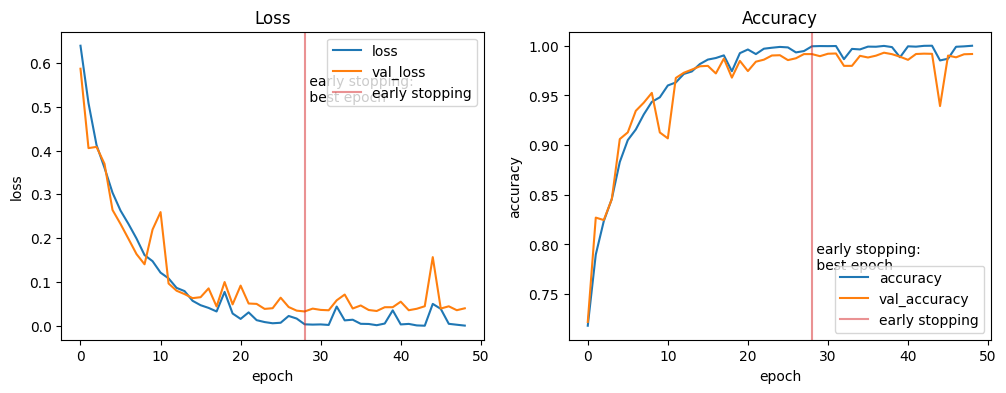

In [7]:
#preia antrenarea din memorie
import pandas as pd
import matplotlib.pyplot as plt

# Încarcă istoricul din fișierul CSV
df = pd.read_csv('/kaggle/input/model-history-training-final/training_history_final.csv')

# Adăugăm o coloană 'epoch' care reprezintă indicele fiecărui rând
df['epoch'] = df.index

# Creăm un dicționar cu valorile necesare pentru plot
hist = {
    'loss': df['loss'].values,
    'val_loss': df['val_loss'].values,
    'accuracy': df['accuracy'].values,
    'val_accuracy': df['val_accuracy'].values
}

# Configurare plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot pentru Loss
ax[0].plot(hist['loss'], label='loss')
ax[0].plot(hist['val_loss'], label='val_loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')

# Mark the early stopping epoch (care este momentul cu min. val_loss)
es_best_epoch = df['val_loss'].idxmin()  # Epoca cu valoarea minimă pentru 'val_loss'
ax[0].axvline(x=es_best_epoch, label='early stopping', color='tab:red', alpha=0.5)
r = .2
temp_y = r*min(hist['loss'])+(1-r)*max(hist['loss'])
ax[0].annotate(' early stopping:\n best epoch', xy=(es_best_epoch, temp_y))
ax[0].set_title('Loss')
ax[0].legend()

# Plot pentru Accuracy
ax[1].plot(hist['accuracy'], label='accuracy')
ax[1].plot(hist['val_accuracy'], label='val_accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')

# Mark the early stopping epoch (care este momentul cu min. val_loss)
r = .8
temp_y = r*min(hist['accuracy'])+(1-r)*max(hist['accuracy'])
ax[1].axvline(x=es_best_epoch, label='early stopping', color='tab:red', alpha=0.5)
ax[1].annotate(' early stopping:\n best epoch', xy=(es_best_epoch, temp_y))
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()


## Secțiunea 4.4 - Modelele

In [ ]:
#run the model without training
import tensorflow as tf
from tensorflow import keras
model = keras.models.load_model('/kaggle/input/cnn_eeg_seizure_model/tensorflow2/default/1/CHB_MIT_sz_detec.h5')

In [ ]:
#run the model without training
import tensorflow as tf
from tensorflow import keras
model = keras.models.load_model('/kaggle/input/cnn_eeg_model_rs2023/tensorflow2/default/1/CHB_MIT_sz_detec_rs2023.h5')

In [2]:
#run the model without training
import tensorflow as tf
from tensorflow import keras
model = keras.models.load_model('/kaggle/input/cnn_eeg_seizure_model_final/tensorflow2/default/1/CHB_MIT_sz_detec_final.h5')

I0000 00:00:1749571221.462301      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749571221.463222      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Secțiunea 5 - Evaluarea Modelului

In [14]:
def sampling_data_pred(f, verbose=True):
    #list_signals = []
    #list_is_sz = []
    #n_sample = 40
    if verbose==True:
        print('{}: Reading. '.format(f))
    temp_edf =  mne.io.read_raw_edf(f)
    temp_labels = temp_edf.ch_names
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6 #Extrage datele EEG pentru canalele specifice și le convertește în microvolți

        if os.path.exists(f+'.seizures'):
            if verbose==True:
                print('sz exists.', end=' ')
            temp_annotation = wfdb.rdann(f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1

        temp_len = temp_edf.n_times

        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
        step_window = time_window*fs
        step = time_step*fs

        # sampling all signals
        temp_array_signals = np.array([temp_signals[:, i*step:i*step+step_window] for i in range((temp_len-step_window)//step)])
        temp_is_sz_ind = np.array([temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)])
    else:
        if verbose==True:
            print('EEG {}: Not appropriate channel labels. Reading skipped.'.format(n))

    return temp_array_signals, temp_is_sz_ind

In [8]:
mne.set_log_level(verbose='ERROR') #show only error messages

In [15]:
# reading files and prediction

list_pred = []
list_true = []

for f in tqdm.tqdm(files_test):
    array_signals, array_is_sz = sampling_data_pred(f, verbose=False)
    array_signals = array_signals[:, :, ::2, np.newaxis]
    
    list_pred.append(model.predict(array_signals, verbose=0))
    list_true.append(array_is_sz)

  0%|          | 0/137 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1749571513.858913      94 service.cc:148] XLA service 0x79962400d9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749571513.859701      94 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749571513.859729      94 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749571513.987971      94 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749571517.444625      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 137/137 [07:15<00:00,  3.18s/it]


In [ ]:
import numpy as np

# Afișează doar primele 5 predicții cu primele 3 valori din fiecare
for i in range(5):
    print(f"Predicția {i+1}: {np.array(list_pred[i])[:3]}")


In [ ]:
print(list_pred[:5])  # Primele 5 predicții
print(list_true[:5])  # Primele 5 etichete adevărate

In [ ]:
import pickle

with open("predictions.pkl", "wb") as f:
    pickle.dump((list_pred, list_true), f)

In [ ]:
import pickle

# Încărcare dataset din fișierul salvat
file_path = "/kaggle/input/evaluare/predictions.pkl"

with open(file_path, "rb") as f:
    list_pred, list_true = pickle.load(f)

print("Datele au fost încărcate! Avem", len(list_pred), "predicții și", len(list_true), "etichete reale.")


In [ ]:
array_signals.shape

In [ ]:
array_is_sz.shape

Arata fisierul si predictiile

In [ ]:
# import numpy as np
# import pandas as pd

# # Aplatizează predicțiile și etichetele într-un singur array
# y_pred_all = np.concatenate(list_pred)
# y_true_all = np.concatenate(list_true)

# # Aplatizare în cazul în care predicțiile sunt în format coloană
# if y_pred_all.ndim > 1 and y_pred_all.shape[1] == 1:
#     y_pred_all = y_pred_all.flatten()

# # Creează DataFrame cu primele 30 de exemple
# df = pd.DataFrame({
#     'Predicted': y_pred_all[:50000],
#     'Actual': y_true_all[:50000]
# })

# # Adaugă eticheta binară (0 sau 1) pe baza unui prag de 0.5
# df['Predicted_Label'] = (df['Predicted'] >= 0.5).astype(int)

# # Salvează tabelul într-un fișier CSV
# df.to_csv('model_predictions_sample.csv', index=False)

# # Confirmare
# print("Fișierul 'model_predictions_sample.csv' a fost salvat.")
#-------------------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Aplatizează predicțiile și etichetele
y_pred_all = np.concatenate(list_pred)
y_true_all = np.concatenate(list_true)

# Aplatizare dacă e necesar
if y_pred_all.ndim > 1 and y_pred_all.shape[1] == 1:
    y_pred_all = y_pred_all.flatten()

# Creează DataFrame complet
df_all = pd.DataFrame({
    'Predicted': y_pred_all,
    'Actual': y_true_all
})

# Filtrare: doar segmente cu criză reală
df_sz_only = df_all[df_all['Actual'] > 0]

# Adaugă eticheta binară de predicție
df_sz_only['Predicted_Label'] = (df_sz_only['Predicted'] >= 0.5).astype(int)

# Salvează fișierul CSV
df_sz_only.to_csv('model_predictions_only_seizures_rs2023.csv', index=False)

print("Fișierul 'model_predictions_only_seizures_rs2023.csv' a fost salvat.")


## Secțiunea 5.1 - Precision, Recall, F1-score

In [ ]:
# print("Număr total segmente cu crize:", np.sum(y_true_all > 0))
# print()
# print(f"Număr total de crize (în etichetele reale): {np.sum(y_true_all)}")
# print()
# print(f"Dimensiune y_true_all: {y_true_all.shape}")
# print(f"Dimensiune y_pred_all: {y_pred_all.shape}")
# print()
# print("Valori unice în y_true_all:", np.unique(y_true_all))
# print("Dimensiune y_true_all:", y_true_all.shape)
# print("Suma elementelor:", np.sum(y_true_all))

import pickle
import numpy as np

# Încărcarea datelor salvate
file_path = "/kaggle/input/evaluare/predictions.pkl"

with open(file_path, "rb") as f:
    list_pred, list_true = pickle.load(f)

# Convertim listele în array-uri NumPy pentru analiză
y_pred_all = np.array(list_pred)
y_true_all = np.array(list_true)

# Analiza datelor
print("Număr total segmente cu crize:", np.sum(y_true_all > 0))
print()
print(f"Număr total de crize (în etichetele reale): {np.sum(y_true_all)}")
print()
print(f"Dimensiune y_true_all: {y_true_all.shape}")
print(f"Dimensiune y_pred_all: {y_pred_all.shape}")
print()
print("Valori unice în y_true_all:", np.unique(y_true_all))
print("Dimensiune y_true_all:", y_true_all.shape)
print("Suma elementelor:", np.sum(y_true_all))

In [ ]:
print(len(list_true))
print()
print(len(list_pred))

In [16]:
from sklearn import metrics

# threshold = 0.5
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.5)
print(report)

# threshold = 0.9
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.9)
print(report)

# threshold = 0.4
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.4)
print(report)

              precision    recall  f1-score   support

       False       1.00      0.98      0.99    186865
        True       0.09      0.58      0.15       629

    accuracy                           0.98    187494
   macro avg       0.54      0.78      0.57    187494
weighted avg       1.00      0.98      0.99    187494

              precision    recall  f1-score   support

       False       1.00      0.99      0.99    186865
        True       0.12      0.56      0.20       629

    accuracy                           0.99    187494
   macro avg       0.56      0.77      0.60    187494
weighted avg       1.00      0.99      0.99    187494

              precision    recall  f1-score   support

       False       1.00      0.98      0.99    186865
        True       0.08      0.59      0.15       629

    accuracy                           0.98    187494
   macro avg       0.54      0.78      0.57    187494
weighted avg       1.00      0.98      0.99    187494



## Secțiunea 5.2 - Curba ROC

In [ ]:
roc = metrics.roc_curve(np.concatenate(list_true)>0, np.concatenate(list_pred))
auc = metrics.roc_auc_score(np.concatenate(list_true)>0, np.concatenate(list_pred))
plt.figure(figsize=(4, 4))
plt.plot(roc[0][np.argmin(np.abs(roc[2]-1)):], roc[1][np.argmin(np.abs(roc[2]-1)):])
plt.xlabel('FPR: false positive rate')
plt.ylabel('TPR: true positive rate')
plt.title('ROC curve: AUC score = {:.2f}'.format(auc))

th = [.1, .2, .5, .9, .95, 1.]
ind = [np.argmin(np.abs(roc[2]-l)) for l in th]
plt.scatter(roc[0][ind], roc[1][ind], s=15)
for i, l in enumerate(ind):
    plt.annotate("{}".format(th[i]), xy=(roc[0][l], roc[1][l]))
#plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], color='black', linewidth=1)
plt.ylim(-.05, 1.05)
plt.xlim(-.05, 1.05)
plt.grid()
#plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.hist(np.concatenate(list_pred), bins=50)
plt.xlabel('Valori predicții')
plt.ylabel('Frecvență')
plt.title('Distribuția scorurilor de predicție')
plt.show()


In [ ]:
print("Distribuția etichetelor reale:", np.unique(np.concatenate(list_true), return_counts=True))

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true_labels, y_pred_all)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


## Secțiunea 5.3 - Matricea de confuzie

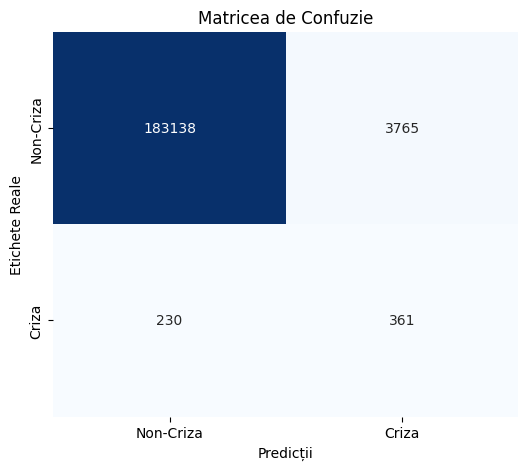

Număr de non-crize reale (TN): 183138
Număr de crize reale (TP): 361
Număr de non-crize prezise greșit (FP): 3765
Număr de crize prezise greșit (FN): 230

Explicație:
Din totalul crizelor reale (591), modelul a prezis corect 361 crize și a prezis greșit 230.
Din totalul non-crizelor reale (186903), modelul a prezis corect 183138 non-crize și a prezis greșit 3765.


In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred_all = np.concatenate(list_pred)
y_true_all = np.concatenate(list_true)

if y_pred_all.ndim > 1 and y_pred_all.shape[1] == 1:
    y_pred_all = y_pred_all.flatten()

y_pred_labels = (y_pred_all >= 0.5).astype(int)
y_true_labels = (y_true_all >= 0.5).astype(int)

cm = confusion_matrix(y_true_labels, y_pred_labels)

cm_df = pd.DataFrame(cm, index=["Non-Criza", "Criza"], columns=["Non-Criza", "Criza"])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matricea de Confuzie")
plt.xlabel("Predicții")
plt.ylabel("Etichete Reale")
plt.show()

TN, FP, FN, TP = cm.ravel()

print(f"Număr de non-crize reale (TN): {TN}")
print(f"Număr de crize reale (TP): {TP}")
print(f"Număr de non-crize prezise greșit (FP): {FP}")
print(f"Număr de crize prezise greșit (FN): {FN}")

print("\nExplicație:")
print(f"Din totalul crizelor reale ({TP + FN}), modelul a prezis corect {TP} crize și a prezis greșit {FN}.")
print(f"Din totalul non-crizelor reale ({TN + FP}), modelul a prezis corect {TN} non-crize și a prezis greșit {FP}.")


In [ ]:
print("Distribuție etichete reale:", np.unique(y_true_labels, return_counts=True))
print("Distribuție etichete prezise:", np.unique(y_pred_labels, return_counts=True))

## Secțiunea 5.4 - Seizure detection point

In [ ]:
for i, f in enumerate(files_test):
    if os.path.exists(f+'.seizures'):
        print('Index = {} has seizures: {}'.format(i, f))

In [ ]:
def moving_ave(a, n):
    if len(a.shape)!=1:
        print('Not 1 dimension array. return nothing.')
        return
    temp = np.zeros(a.size-n)
    for i in range(n):
        temp = temp+a[i:-n+i]
    temp = temp/n
    
    return temp


# get signals and labels from test data.
n=100
array_signals, array_is_sz = sampling_data_pred(files_test[n])

# preprocess
array_signals=array_signals[:, :, ::2, np.newaxis]

# use deep learning model
pred = model.predict(array_signals)

In [ ]:
time_window = 8
time_step = 4
mv_win = 3

fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(np.arange(pred.size)*time_step, pred.flatten(), alpha=0.7, label='deep learning model pred')
ax.plot(np.arange(pred.size)*time_step, array_is_sz, alpha=.7, label='True label')

pred_moving_ave = moving_ave(pred.flatten(), mv_win)
pred_peaks, _ = find_peaks(pred_moving_ave, height=.95, distance=6)
ax.plot(np.arange(pred.size-mv_win)*time_step, pred_moving_ave,
        alpha=.9, label='pred - moving ave', color='tab:pink', zorder=0)
ax.scatter(pred_peaks*time_step, pred_moving_ave[pred_peaks], s=20, color='tab:red')

ax.set_xlabel('time (s)')
ax.set_ylabel('p')
ax.set_xlim(0, pred.size*time_step+500)
ax.legend(loc='upper right')
plt.show()

In [ ]:
if pred_peaks.size==0:
    print('No seizure detected.')
else:
    f = files_test[n]
    temp_edf =  mne.io.read_raw_edf(f)
    temp_labels = temp_edf.ch_names
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

    fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
    for n_peak in range(pred_peaks.size):
        ind_peak = pred_peaks[n_peak]*time_step*fs
        backward_steps = 30*fs
        forward_steps = 15*fs
        vertical_width=500

        fig, ax = plt.subplots(figsize=(10, 6))
        for i in range(temp_signals.shape[0]):
            ax.plot(np.arange(ind_peak-backward_steps, ind_peak+forward_steps)/fs,
                    temp_signals[i, ind_peak-backward_steps:ind_peak+forward_steps]+i*vertical_width, linewidth=0.5, color='tab:blue')
            ax.annotate(ch_labels[i], xy=((ind_peak-backward_steps)/fs, i*vertical_width))
        ax.axvline(x=ind_peak/fs, color='tab:red', alpha=0.5, label='Seizure detection point')
        ax.invert_yaxis()
        ax.legend(loc='upper right')
        plt.show()
    #ax.set_xlim(0, 8)

    temp_edf.close()

# EXTRA

**HEATMAPS**  **training part**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm  # pentru bara de progres

# Creează foldere pentru imaginile de train
os.makedirs('/kaggle/working/heatmaps/train/criza', exist_ok=True)
os.makedirs('/kaggle/working/heatmaps/train/non_criza', exist_ok=True)

# Funcție care salvează heatmap-ul
def save_heatmap(signal, path):
    plt.figure(figsize=(4, 4))
    plt.axis('off')
    plt.pcolormesh(signal, cmap='gray')
    plt.gca().invert_yaxis()
    plt.tight_layout(pad=0)
    plt.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Salvează imaginile de antrenare
for idx in tqdm(range(X_train.shape[0]), desc="Generăm heatmap-uri pentru train"):
    label = 'criza' if y_train[idx] else 'non_criza'
    save_path = f'/kaggle/working/heatmaps/train/{label}/{idx}.png'
    save_heatmap(X_train[idx, :, :], save_path)


In [ ]:
import zipfile
import os

# Setează calea către folderul care conține imaginile
folder_path = '/kaggle/working/heatmaps/train'

# Numele fișierului zip
zip_file = '/kaggle/working/heatmaps_train.zip'

# Creează un fișier zip
with zipfile.ZipFile(zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Parcurge folderele din directory
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Adaugă fiecare fișier .png la arhivă
            if file.endswith('.png'):
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_path))

print(f'Fișierul zip a fost creat la {zip_file}')

import shutil

# Muta arhiva într-un loc accesibil pentru download
shutil.move(zip_file, '/kaggle/working/heatmaps_train.zip')

# Link de descărcare
from IPython.display import FileLink

# Crează un link de descărcare
FileLink(r'/kaggle/working/heatmaps_train.zip')

In [ ]:
import pandas as pd
import os

image_paths = []
labels = []

base_path = '/kaggle/working/heatmaps/train'

for label in ['criza', 'non_criza']:
    full_path = os.path.join(base_path, label)
    for fname in os.listdir(full_path):
        if fname.endswith('.png'):
            image_paths.append(os.path.join(full_path, fname))
            labels.append(label)

train_df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

train_df.to_csv('/kaggle/working/train_dataset.csv', index=False)

print("CSV-ul a fost creat pe baza imaginilor existente.")


In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Creează foldere pentru imaginile de train
os.makedirs('/kaggle/working/heatmaps/train/criza', exist_ok=True)
os.makedirs('/kaggle/working/heatmaps/train/non_criza', exist_ok=True)

# Funcție care salvează heatmap-ul
def save_heatmap(signal, path):
    plt.figure(figsize=(4, 4))
    plt.axis('off')
    plt.pcolormesh(signal, cmap='gray')
    plt.gca().invert_yaxis()
    plt.tight_layout(pad=0)
    plt.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Creăm o listă pentru căile fișierelor și etichetele corespunzătoare
image_paths = []
labels = []

# Salvează imaginile de antrenare
for idx in tqdm(range(X_train.shape[0]), desc="Generăm heatmap-uri pentru train"):
    label = 'criza' if y_train[idx] else 'non_criza'
    save_path = f'/kaggle/working/heatmaps/train/{label}/{idx}.png'
    save_heatmap(X_train[idx, :, :], save_path)
    
    # Adăugăm calea fișierului și eticheta în liste
    image_paths.append(save_path)
    labels.append(label)

# Creăm un DataFrame din listele de căi și etichete
train_df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Salvăm DataFrame-ul ca fișier CSV
train_df.to_csv('/kaggle/working/train_dataset.csv', index=False)

print("Dataset-ul pentru train a fost salvat ca fișier CSV.")


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# from tqdm import tqdm  # pentru bara de progres

# # Creează foldere pentru imagini
# os.makedirs('/kaggle/working/heatmaps/train/criza', exist_ok=True)
# os.makedirs('/kaggle/working/heatmaps/train/non_criza', exist_ok=True)
# os.makedirs('/kaggle/working/heatmaps/test/criza', exist_ok=True)
# os.makedirs('/kaggle/working/heatmaps/test/non_criza', exist_ok=True)

# # Funcție care salvează heatmap-ul
# def save_heatmap(signal, path):
#     plt.figure(figsize=(4, 4))
#     plt.axis('off')
#     plt.pcolormesh(signal, cmap='gray')  # poți schimba cmap dacă vrei alt efect
#     plt.gca().invert_yaxis()
#     plt.tight_layout(pad=0)
#     plt.savefig(path, bbox_inches='tight', pad_inches=0)
#     plt.close()

# # Salvează imaginile de antrenare
# for idx in tqdm(range(X_train.shape[0]), desc="Generăm heatmap-uri pentru train"):
#     label = 'criza' if y_train[idx] else 'non_criza'
#     save_path = f'/kaggle/working/heatmaps/train/{label}/{idx}.png'
#     save_heatmap(X_train[idx, :, :], save_path)

# # Salvează imaginile de testare
# for idx in tqdm(range(X_test.shape[0]), desc="Generăm heatmap-uri pentru test"):
#     label = 'criza' if y_test[idx] else 'non_criza'
#     save_path = f'/kaggle/working/heatmaps/test/{label}/{idx}.png'
#     save_heatmap(X_test[idx, :, :], save_path)


In [ ]:
# import numpy as np
# import os
# import random
# import gc
# import tqdm
# import logging
# import mne
# import wfdb
# import re

# # Creează un sistem de logare pentru monitorizarea fișierelor procesate
# logger = logging.getLogger(__name__)
# fh = logging.FileHandler('read_files.log')
# logger.addHandler(fh)

# # Parametrii pentru segmentare
# time_window = 8  # Fereastră de 8 secunde
# time_step = 4  # Suprapunere de 50% (alunecare de 4 secunde)
# p = 0.01  # Proporția de segmente fără crize extrase
# counter = 0  # Contor pentru numărul total de segmente EEG extrase

# # Se citește fiecare fișier EEG
# for temp_f in files_train:  
#     temp_edf = mne.io.read_raw_edf(temp_f)  
#     temp_labels = temp_edf.ch_names  

#     # Verifică dacă toate canalele necesare sunt prezente
#     if sum([any([0 if re.match(c, l) is None else 1 for l in temp_edf.ch_names]) for c in ch_labels]) == len(ch_labels):

#         fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))  # Rata de eșantionare
#         step_window = time_window * fs  # Dimensiunea fiecărei ferestre (în eșantioane)
#         step = time_step * fs  # Alunecare de **4 secunde** pentru suprapunere de 50%

#         # Începem segmentarea **de la secunda 1** -> calculăm indexul corespunzător în eșantioane
#         start_index = fs  # 1 sec * frecvența de eșantionare

#         temp_is_sz = np.zeros((temp_edf.n_times,))  # Inițializare array cu 0 (fără criză)

#         # Verifică dacă fișierul .seizures există și marchează crizele
#         if os.path.exists(temp_f + '.seizures'):
#             temp_annotation = wfdb.rdann(temp_f, 'seizures')
#             for i in range(int(temp_annotation.sample.size / 2)):
#                 temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1  # Marcare crize

#         temp_len = temp_edf.n_times

#         # Crearea vectorului de proporție a crizelor **pornind de la secunda 1**
#         temp_is_sz_ind = np.array([
#             temp_is_sz[start_index + i * step:start_index + i * step + step_window].sum() / step_window
#             for i in range((temp_len - start_index - step_window) // step)
#         ])

#         # Se calculează câte segmente cu și fără crize vor fi extrase
#         temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
#         temp_1_sample_size = np.where(temp_is_sz_ind > 0)[0].size

#         counter += temp_0_sample_size + temp_1_sample_size

#     temp_edf.close()

# # Crearea array-urilor după ce s-au calculat dimensiunile totale
# array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
# array_is_sz = np.zeros(counter, dtype=bool)
# source_files = []

# # Citește din nou fișierele și extrage efectiv semnalele
# counter = 0
# for n, temp_f in enumerate(tqdm.tqdm(files_train)):
#     to_log = 'No. {}: Reading. '.format(n)
#     temp_edf = mne.io.read_raw_edf(temp_f)

#     temp_labels = temp_edf.ch_names
#     n_label_match = sum([any([0 if re.match(c, l) is None else 1 for l in temp_edf.ch_names]) for c in ch_labels])

#     if n_label_match == len(ch_labels):
#         ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l) is not None])[0]: c for c in ch_labels}
#         temp_edf.rename_channels(ch_mapping)

#         temp_is_sz = np.zeros((temp_edf.n_times,))
#         temp_signals = temp_edf.get_data(picks=ch_labels) * 1e6

#         if os.path.exists(temp_f + '.seizures'):
#             to_log += 'sz exists.'
#             temp_annotation = wfdb.rdann(temp_f, 'seizures')
#             for i in range(int(temp_annotation.sample.size / 2)):
#                 temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1

#         temp_len = temp_edf.n_times

#         fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))  # Frecvența de eșantionare
#         step_window = time_window * fs
#         step = time_step * fs  # Acum alunecă 4 secunde pentru suprapunere de 50%

#         # **Pornim de la secunda 2**
#         start_index = 2*fs  

#         temp_is_sz_ind = np.array([
#             temp_is_sz[start_index + i * step:start_index + i * step + step_window].sum() / step_window
#             for i in range((temp_len - start_index - step_window) // step)
#         ])
#         del temp_is_sz

#         temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
#         temp_1_sample_size = np.where(temp_is_sz_ind > 0)[0].size

#         # Adăugarea semnalelor cu crize
#         temp_ind = list(np.where(temp_is_sz_ind > 0)[0])
#         for i in temp_ind:
#             array_signals[counter, :, :] = temp_signals[:, start_index + i * step:start_index + i * step + step_window]
#             array_is_sz[counter] = True
#             source_files.append(temp_f)
#             counter += 1

#         # Adăugarea semnalelor fără crize
#         temp_ind = random.sample(list(np.where(temp_is_sz_ind == 0)[0]), temp_0_sample_size)
#         for i in temp_ind:
#             array_signals[counter, :, :] = temp_signals[:, start_index + i * step:start_index + i * step + step_window]
#             array_is_sz[counter] = False
#             source_files.append(temp_f)
#             counter += 1

#         to_log += '{} signals added: {} w/o sz, {} w/ sz.'.format(temp_0_sample_size + temp_1_sample_size, temp_0_sample_size, temp_1_sample_size)

#     else:
#         to_log += 'Not appropriate channel labels. Reading skipped.'.format(n)

#     logger.info(to_log)
#     temp_edf.close()

#     if n % 10 == 0:
#         gc.collect()
# gc.collect()

# # Salvarea array-urilor rezultate
# np.save('/kaggle/working/signal_samples.npy', array_signals)
# np.save('/kaggle/working/is_sz.npy', array_is_sz)
# np.save('/kaggle/working/source_files.npy', np.array(source_files))

# array_signals.shape  # (num_windows, num_channels, window_length_samples)

In [ ]:
# #incepand cu secundele 1,2,3 pentru toti copiii
# !pip install wfdb

# import logging
# import random
# import numpy as np
# import mne
# import wfdb
# import os
# import gc
# import tqdm
# import matplotlib.pyplot as plt

# # Set up logging
# logger = logging.getLogger(__name__)
# fh = logging.FileHandler('read_files.log')
# logger.addHandler(fh)

# # Window parameters
# time_window = 8  # 8 seconds
# fs = 256  # default sampling frequency
# step_window = time_window * fs
# p = 0.01

# # Calculate total segments across all files
# counter = 0
# for temp_f in files_train:
#     temp_edf = mne.io.read_raw_edf(temp_f)
#     if all(any(re.match(c, l) for l in temp_edf.ch_names) for c in ch_labels):
#         temp_len = temp_edf.n_times
#         temp_is_sz = np.zeros(temp_len)
#         if os.path.exists(temp_f + '.seizures'):
#             temp_annotation = wfdb.rdann(temp_f, 'seizures')
#             for i in range(temp_annotation.sample.size // 2):
#                 temp_is_sz[temp_annotation.sample[i * 2] : temp_annotation.sample[i * 2 + 1]] = 1
        
#         # Include start offsets (0s, 1s, 2s, 3s)
#         for offset in range(fs, 4 * fs, fs):
#             temp_is_sz_ind = np.array([
#                 temp_is_sz[i * fs + offset : i * fs + offset + step_window].sum() / step_window
#                 for i in range((temp_len - offset - step_window) // fs)
#             ])
#             counter += round(p * np.where(temp_is_sz_ind == 0)[0].size)
#             counter += np.where(temp_is_sz_ind > 0)[0].size
#     temp_edf.close()

# del temp_is_sz

# # Initialize arrays
# array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
# array_is_sz = np.zeros(counter, dtype=bool)
# source_files = []

# # Extract and store segments
# counter = 0
# for n, temp_f in enumerate(tqdm.tqdm(files_train)):
#     temp_edf = mne.io.read_raw_edf(temp_f)
#     if all(any(re.match(c, l) for l in temp_edf.ch_names) for c in ch_labels):
#         temp_signals = temp_edf.get_data(picks=ch_labels) * 1e6
#         temp_len = temp_edf.n_times
#         temp_is_sz = np.zeros(temp_len)
#         if os.path.exists(temp_f + '.seizures'):
#             temp_annotation = wfdb.rdann(temp_f, 'seizures')
#             for i in range(temp_annotation.sample.size // 2):
#                 temp_is_sz[temp_annotation.sample[i * 2] : temp_annotation.sample[i * 2 + 1]] = 1
        
#         for offset in range(0, 4 * fs, fs):
#             temp_is_sz_ind = np.array([
#                 temp_is_sz[i * fs + offset : i * fs + offset + step_window].sum() / step_window
#                 for i in range((temp_len - offset - step_window) // fs)
#             ])
            
#             # Extract seizure data
#             temp_ind = list(np.where(temp_is_sz_ind > 0)[0])
#             for i in temp_ind:
#                 array_signals[counter, :, :] = temp_signals[:, i * fs + offset : i * fs + offset + step_window]
#                 array_is_sz[counter] = True
#                 source_files.append(temp_f)
#                 counter += 1
            
#             # Extract non-seizure data
#             temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
#             temp_ind = random.sample(list(np.where(temp_is_sz_ind == 0)[0]), temp_0_sample_size)
#             for i in temp_ind:
#                 array_signals[counter, :, :] = temp_signals[:, i * fs + offset : i * fs + offset + step_window]
#                 array_is_sz[counter] = False
#                 source_files.append(temp_f)
#                 counter += 1
#     temp_edf.close()
#     if n % 10 == 0:
#         gc.collect()

# gc.collect()
# np.save('/kaggle/working/signal_samples_2.npy', array_signals)
# np.save('/kaggle/working/is_sz_2.npy', array_is_sz)
# np.save('/kaggle/working/source_files.npy', np.array(source_files))

# # Visualization of window distribution
# signals = np.load('/kaggle/working/signal_samples_2.npy')
# labels = np.load('/kaggle/working/is_sz_2.npy')
# sources = np.load('/kaggle/working/source_files_2.npy')

# print("Total number of windows:", signals.shape[0])
# print("Number of seizure windows:", labels.sum())
# print("Number of non-seizure windows:", len(labels) - labels.sum())

# plt.figure(figsize=(10, 6))
# plt.hist(labels, bins=2, color='skyblue', rwidth=0.8)
# plt.xticks([0, 1], ["Non-Seizure", "Seizure"])
# plt.title("Distribution of Seizure and Non-Seizure Windows")
# plt.show()

In [ ]:
# import mne

# # Verifică canalele disponibile în primul fișier chb02
# temp_f = [f for f in files_train if "chb02_" in f][0]
# raw = mne.io.read_raw_edf(temp_f, preload=False)
# print(raw.ch_names)

In [ ]:
# #incepand cu secundele 1,2,3 pentru chb_02
# import logging
# import random
# import numpy as np
# import mne
# import wfdb
# import os
# import gc
# import tqdm
# import matplotlib.pyplot as plt

# # Set up logging
# logger = logging.getLogger(__name__)
# fh = logging.FileHandler('read_files_chb02.log')
# logger.addHandler(fh)

# # Window parameters
# time_window = 8  # 8 seconds
# fs = 256  # default sampling frequency
# step_window = time_window * fs
# p = 0.01

# ch_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 
#              'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 
#              'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 
#              'FT10-T8', 'T8-P8-1']

# # Filter files for chb02 only
# files_chb02 = [f for f in files_train if "chb02_" in f]

# # Calculate total segments for chb02
# counter = 0
# for temp_f in files_chb02:
#     temp_edf = mne.io.read_raw_edf(temp_f)
#     if all(any(re.match(c, l) for l in temp_edf.ch_names) for c in ch_labels):
#         temp_len = temp_edf.n_times
#         temp_is_sz = np.zeros(temp_len)
#         if os.path.exists(temp_f + '.seizures'):
#             temp_annotation = wfdb.rdann(temp_f, 'seizures')
#             for i in range(temp_annotation.sample.size // 2):
#                 temp_is_sz[temp_annotation.sample[i * 2] : temp_annotation.sample[i * 2 + 1]] = 1
        
#         # Include start offsets (1s, 2s, 3s)
#         for offset in [1 * fs, 2 * fs, 3 * fs]:
#             temp_is_sz_ind = np.array([
#                 temp_is_sz[i * fs + offset : i * fs + offset + step_window].sum() / step_window
#                 for i in range((temp_len - offset - step_window) // fs)
#             ])
#             counter += round(p * np.where(temp_is_sz_ind == 0)[0].size)
#             counter += np.where(temp_is_sz_ind > 0)[0].size
#     temp_edf.close()

# del temp_is_sz

# # Initialize arrays
# array_signals_02 = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
# array_is_sz_02 = np.zeros(counter, dtype=bool)
# source_files = []

# # Extract and store segments for chb02
# counter = 0
# for n, temp_f in enumerate(tqdm.tqdm(files_chb02)):
#     temp_edf = mne.io.read_raw_edf(temp_f)
#     if all(any(re.match(c, l) for l in temp_edf.ch_names) for c in ch_labels):
#         temp_signals = temp_edf.get_data(picks=ch_labels) * 1e6
#         temp_len = temp_edf.n_times
#         temp_is_sz = np.zeros(temp_len)
#         if os.path.exists(temp_f + '.seizures'):
#             temp_annotation = wfdb.rdann(temp_f, 'seizures')
#             for i in range(temp_annotation.sample.size // 2):
#                 temp_is_sz[temp_annotation.sample[i * 2] : temp_annotation.sample[i * 2 + 1]] = 1
        
#         # Include start offsets (1s, 2s, 3s)
#         for offset in [1 * fs, 2 * fs, 3 * fs]:
#             temp_is_sz_ind = np.array([
#                 temp_is_sz[i * fs + offset : i * fs + offset + step_window].sum() / step_window
#                 for i in range((temp_len - offset - step_window) // fs)
#             ])
            
#             # Extract seizure data
#             temp_ind = list(np.where(temp_is_sz_ind > 0)[0])
#             for i in temp_ind:
#                 array_signals_02[counter, :, :] = temp_signals[:, i * fs + offset : i * fs + offset + step_window]
#                 array_is_sz_02[counter] = True
#                 source_files.append(temp_f)
#                 counter += 1
            
#             # Extract non-seizure data
#             temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
#             temp_ind = random.sample(list(np.where(temp_is_sz_ind == 0)[0]), temp_0_sample_size)
#             for i in temp_ind:
#                 array_signals_02[counter, :, :] = temp_signals[:, i * fs + offset : i * fs + offset + step_window]
#                 array_is_sz_02[counter] = False
#                 source_files.append(temp_f)
#                 counter += 1
#     temp_edf.close()
#     if n % 10 == 0:
#         gc.collect()

# gc.collect()
# np.save('/kaggle/working/signal_samples_chb02.npy', array_signals)
# np.save('/kaggle/working/is_sz_chb02.npy', array_is_sz)
# np.save('/kaggle/working/source_files_chb02.npy', np.array(source_files))

# # Visualization of window distribution
# signals = np.load('/kaggle/working/signal_samples_chb02.npy')
# labels = np.load('/kaggle/working/is_sz_chb02.npy')
# sources = np.load('/kaggle/working/source_files_chb02.npy')

# print("Total number of windows (chb02):", signals.shape[0])
# print("Number of seizure windows (chb02):", labels.sum())
# print("Number of non-seizure windows (chb02):", len(labels) - labels.sum())

# plt.figure(figsize=(10, 6))
# plt.hist(labels, bins=2, color='skyblue', rwidth=0.8)
# plt.xticks([0, 1], ["Non-Seizure", "Seizure"])
# plt.title("Distribution of Seizure and Non-Seizure Windows (chb02)")
# plt.show()